# Notes about simulation:

# Import packages and set settings

In [1]:
import sys
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

# import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
# import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
# import os
import itertools
from scipy.optimize import fsolve

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [4]:
# sns.palplot(sns.husl_palette(10, l=.7))
# palette_husl = sns.husl_palette(10, l=.7)
# sns.set_palette(palette_husl)
# # palette_husl.as_hex()
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()

## Colors

In [4]:
MAPK_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#8ace88', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#005723'}
MAP2K_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}

# MAPK_palette = {0:'#323232', 50:'#D3D3D3', 150:'#8ace88', 250:'#5ab769', 350: '#319a50', 450:'#117b38', 550:'#005723'}
# MAP2K_palette = {0:'#323232', 50:'#D3D3D3', 150:'#84bcdb', 250:'#5ab769', 350: '#319a50', 450:'#117b38', 550:'#084082'}


palettes = {0:MAPK_palette,
           1:MAP2K_palette,
           2:MAPK_palette,
           3:MAPK_palette,
           4:MAPK_palette }


# Supporting Functions

In [5]:
def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44                                 # volume of a yeast cell
    return molecules/(Na*cell_volume*10**-15)*1000000 # returns uM

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1
    print("Number of runs collected: " + str(len(params_from_file)))
    top = round((runs-empty_data)*top_plotting)

    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
    

    new_params = np.asarray(new_params)

#     print(last_mses)
    idx_top = last_mses.argsort()[:top]
#     print(idx_top)
    top_params = new_params[idx_top]
#     print(top_params)
    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M, colors=None):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    if colors:
        pal3 = sns.set_palette(colors)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]


## Function to plot param behaviors

In [6]:
def plt_param_behaviors(top_params, plt_top, params_constants, initials, gen, doses, time, param, mapk_wt_data=None, mapk_t100a_data=None, mapk_time=None, ptp23D=False):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Wild-type MAPK Simulations'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    palette = palettes.get(param)

    if mapk_wt_data:
        for sig, wt_data in zip(doses, mapk_wt_data):
            ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()

    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Inhibited MAPK Simulations'#'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)

    if mapk_t100a_data:
        for sig, t100a_data in zip(doses, mapk_t100a_data):
#             print(len(t100a_data))
#             if sig == 0:
#                 continue
#                 print(mapk_time_t100a_long)
#                 ax2.plot(mapk_time_t100a_long, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))
#             else:
            ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
#     print(params_constants[1])

    if param == 3:
#         ax1.set_ylim(0,150)
        dt = 0.1
        steps = 5401
        time = np.linspace(0,dt*steps,steps)
    else:
        ax1.set_ylim(0,105)
        ax2.set_ylim(0,105)

#     if params_constants[-1] == 0:
#         ax1.set_ylim(50,105)
    if ptp23D:
        for params in top_params[:plt_top]:
#                 print(params[-1])
#                 params_constants = params_constants[:-1]+[params_constants[-1]*params[-1]]
#                 initials = initials[:-1]+[initials[-1]*params[-1]]
            ptpD_total_protein = [MAP3K_t, MAP2K_t, MAPK_t, 550000*2, 0]
            ptpD_inits = [MAP3K, MAP2K, MAPK, gly, 0]
            ptpD_ss_inits = run_ss(ptpD_inits, ptpD_total_protein, params)
            check = ptpD_total_protein - ptpD_ss_inits
            if (check < 0).any():
                return ((63+69+18*2+27)*100)**2
            else:
                mse_total = 0
                ptp_doses = [0, 150000, 550000]
                for dose, data in zip(doses, mapk_ptp_data):      
                    odes = simulate_wt_experiment(ptpD_ss_inits, ptpD_total_protein, dose, params, time)
                    active = odes[:,param]/params_constants[param]*100
                    ax1.plot(time, active, color=palette.get(dose))                
                    data = simulate_t100a_experiment(ptpD_ss_inits, ptpD_total_protein, sig, params, time)
                    active = data[:,param]/params_constants[param]*100
                    ax2.plot(time, active, '--', color=palette.get(dose))
            
    else:
        for sig in doses:
            for params in top_params[:plt_top]:

                    ss_data = run_ss(initials, params_constants, params)
                    data = simulate_wt_experiment(ss_data, params_constants, sig, params, time)
                    active = data[:,param]/params_constants[param]*100
                    ax1.plot(time, active, color=palette.get(sig))

                    data = simulate_t100a_experiment(ss_data, params_constants, sig, params, time)
                    active = data[:,param]/params_constants[param]*100
                    ax2.plot(time, active, '--', color=palette.get(sig))

#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()
    
def plt_ramp_behaviors(top_params, plt_top, params_constants, initials, gen, time, param, hog1_ramp_data=None, mapk_ramp_time=None):
    fig, (ax1) = plt.subplots(1, 1, figsize=(9,4))
    
    ax1.plot(mapk_ramp_time, hog1_ramp_data[0], 'o', color='Black')
    
    colors = sns.color_palette("Set2", 10)
    pal2 = sns.set_palette(colors)
    
    for params in top_params[:plt_top]:
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_ramp_experiment(ss_data, params_constants, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active)
    plt.show()


In [8]:


# idx_closest_time_points = get_closest_tps(mapk_time,time)

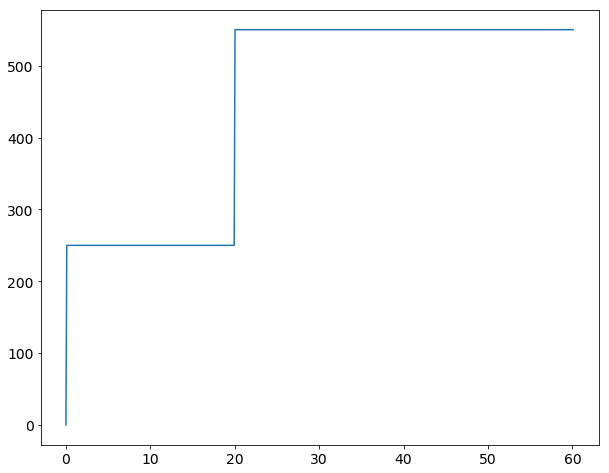

In [9]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
#     if t_step >= 40:
#         sig = 600000
    return sig
plt.plot(time,[signal_ramp_special(x) for x in time])

# Load data to fit to

In [7]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'
ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

mapk_time, mapk_wt_data = model_supp.load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = model_supp.load_csv_data(t100a_folder)
mapk_data_t100a_long = [mapk_t100a_data[0]] 
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_time, map2k_wt_data = model_supp.load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = model_supp.load_csv_data(pbs2_t100a_folder)
mapk_time, mapk_ptp_data = model_supp.load_csv_data(ptpD_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = model_supp.load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]

# exclude far points
mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:]

dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

# M3

## Model Constant Params

In [8]:
MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = molarity_conversion(118+400) # start with all on

PTP = molarity_conversion(118+400)

labelnames = ['$- fb$', '$- PTP$','$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$', '$k_9$',
              '$k_2$', '$k_4$', '$k_6$','$d_1$', '$k_{10}$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$', '$K_{M9}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$', '$K_{M10}$']

minimums = [-4, -4, -4,
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4]

maximums = [ 4, 8, 4,
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)

initials = [MAP3K, MAP2K, MAPK, gly, PTP]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]

mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly', 'PTP']

M3_fxns = model.Model(model.M3, model.simulate_t100a_experiment_M3)


##  190926_kb_M3_long.py


**Notes** 
- Adding ptps to the model

### Inputs

In [9]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190926_kb_M3_long/'
gen = 2000
runs = 2000

model_folder = 'M3/'
sim_id = 'M3_f-all_'

if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


### Gather simulated data

In [11]:
# idx_top_M3, top_params_M3, top, plt_top, new_params, params_from_file, mse_M3, last_mses_M3 = gather_simulated_data(folder, gen, runs, .01)
# df_top_params = pd.DataFrame(top_params_M3)
# df_top_params.columns = labelnames
# df_top_params_log = df_top_params.apply(np.log10)
# df_top_params_log_M_M3 = df_top_params_log.melt(var_name='param', value_name='vals')

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)


Number of runs collected: 1572
Best last gen MSE: 3843.156386000201
Mean last gen MSEs of top 5%: 4268.0036746527085


### Plot

In [41]:
select_top_M3_all = top_params_M3.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

<Figure size 432x288 with 0 Axes>

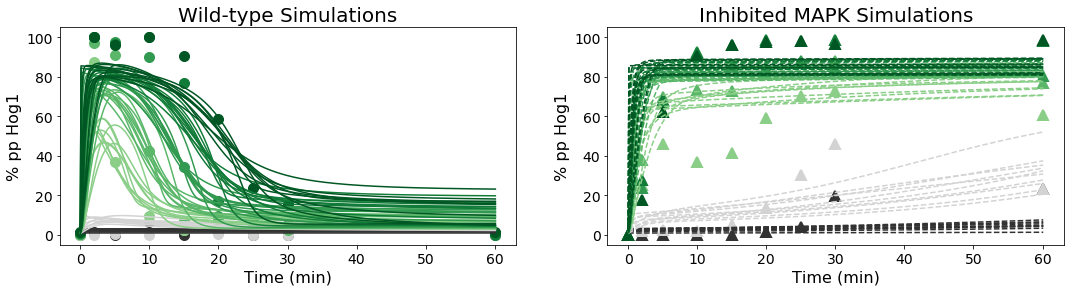

In [70]:
plotting.plt_param_behaviors(M3_fxns, select_top_M3_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

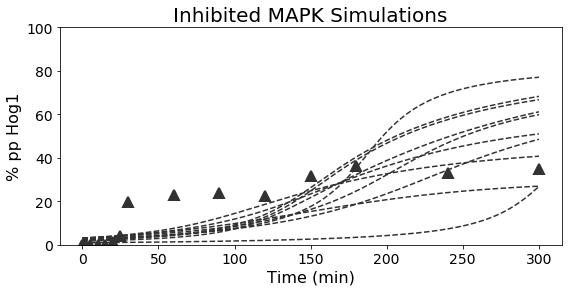

In [44]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M3_fxns, select_top_M3_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

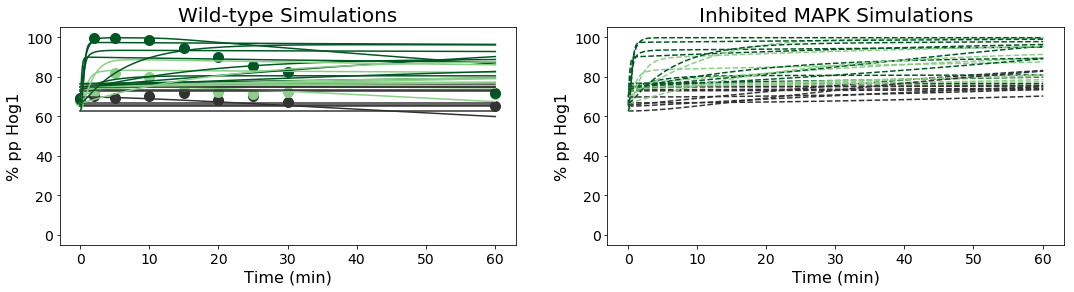

In [75]:
plotting.plt_param_behaviors(M3_fxns, select_top_M3_all, 10, params_constants, initials, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True, save_fig=model_folder+sim_id+'ptp23D')

<Figure size 432x288 with 0 Axes>

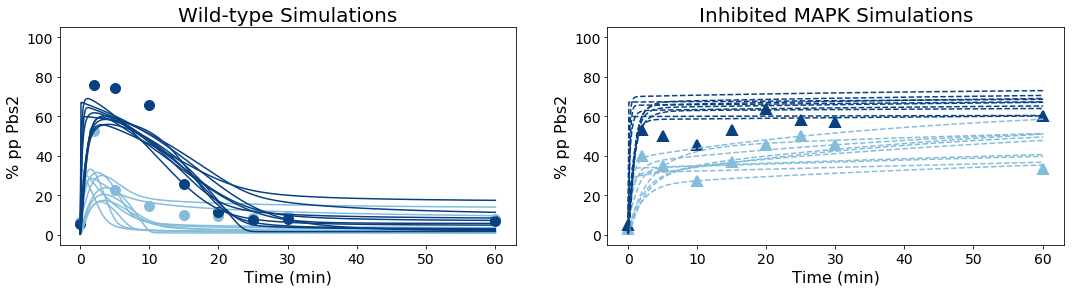

In [45]:
plotting.plt_param_behaviors(M3_fxns, select_top_M3_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

<Figure size 432x288 with 0 Axes>

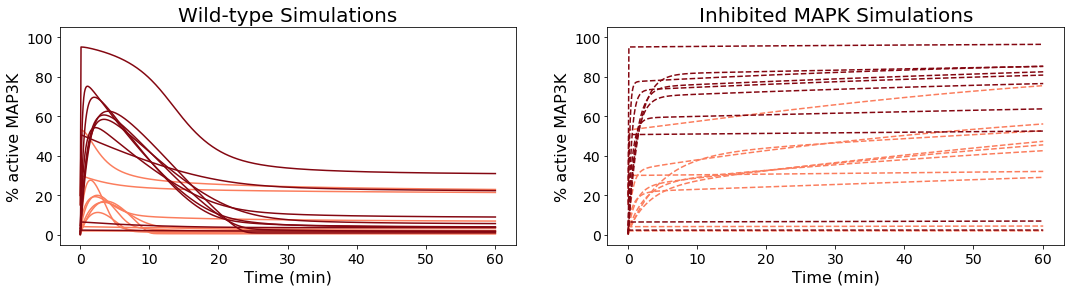

In [46]:
plotting.plt_param_behaviors(M3_fxns, select_top_M3_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

<Figure size 432x288 with 0 Axes>

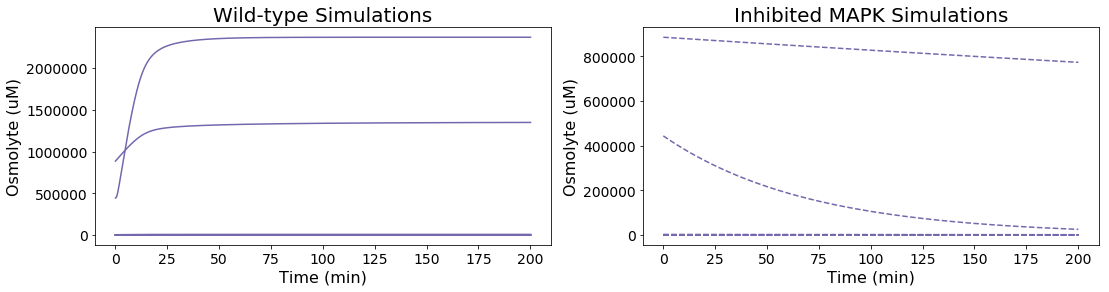

In [47]:
plotting.plt_param_behaviors(M3_fxns, select_top_M3_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

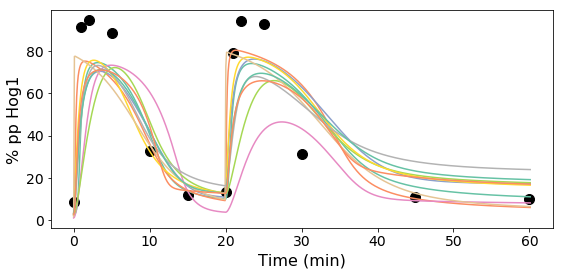

In [49]:
plotting.plt_ramp_behaviors(M3_fxns, select_top_M3_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

In [14]:
M3_fxns = model.Model(model.M3_kb, model.simulate_t100a_experiment_M3)
sims = plotting.simdata_to_list(M3_fxns, last_params, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


9% complete.
19% complete.
29% complete.
39% complete.
49% complete.
59% complete.
69% complete.
79% complete.
89% complete.
99% complete.


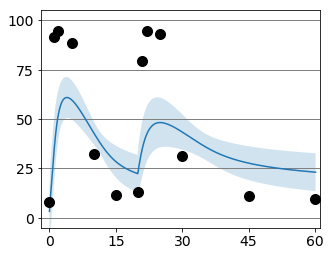

In [16]:
plotting.plt_ramp_cis(sims, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd', save_fig='M3_ramp.pdf')

<Figure size 432x288 with 0 Axes>

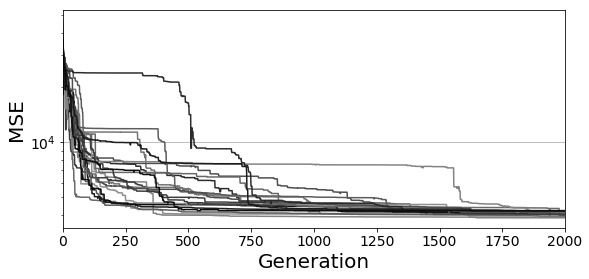

In [59]:
plotting.plt_mses_gen(gen,mse_M3, idx_top_M3, save_fig=model_folder+sim_id+'mses')

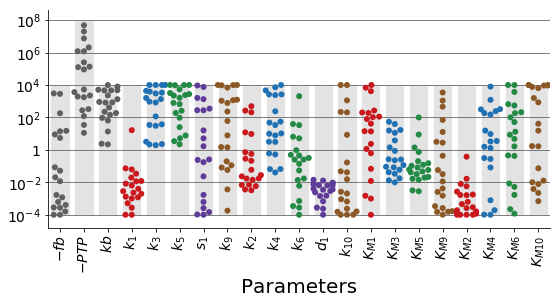

In [62]:
plotting.plt_param_ranges(labelnames, 'M3', dims, df_top_params_log_M_M3, save_fig=model_folder+sim_id+'params')

In [77]:
mses_M3_hog1 = model_supp.get_mse_stats(M3_fxns, top_params_M3, params_constants, initials, ptpD=True)
mses_M3_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2           3           4           5   \
0  5.534334  21.506085  165.864839  126.685119  180.492286  227.968826   
1  5.407075  20.329370  114.096908  133.191565  162.018066  172.038264   
2  8.096578  32.883804  255.996461  190.253336  206.630490  242.853181   
3  4.328758  10.741164  398.347706  299.472270  242.689956  212.563883   
4  6.829816  30.178514  446.123430  399.478181  393.667524  422.644117   

           6           7           8           9      ...              11  \
0  169.854338  180.150779  150.409532  365.603749     ...      376.811696   
1  112.665909  187.212639  167.068319  358.799237     ...      424.291154   
2  161.009905   53.472807  135.218793  247.904882     ...      393.361266   
3  202.624494  292.062325  198.603815  462.072729     ...      229.786862   
4  345.712300  129.437918  162.150149  334.631119     ...      136.259574   

           12          13          14          15          16           17  \
0  463.991579  622.102109  243.049183   71.141516   36.909586   405.719712   
1  490.847029  654.061030  156.155488   79.733378  133.824535   217.176700   
2  460.111369  653.347372  138.152394  175.381218  134.193060   415.367034   
3  349.478719  172.973875  161.415335  108.895129   60.281513  1576.913029   
4  181.196813  306.853471  102.320082   68.499892   90.979125  1234.493355   

          18         19          20  
0  18.862212  71.409014   84.512988  
1  17.595662  17.221885  194.441870  
2  14.735678  12.473544   67.676908  
3  58.688070  26.741265  241.064082  
4  36.882299  27.053945  252.283639  

[5 rows x 21 columns]

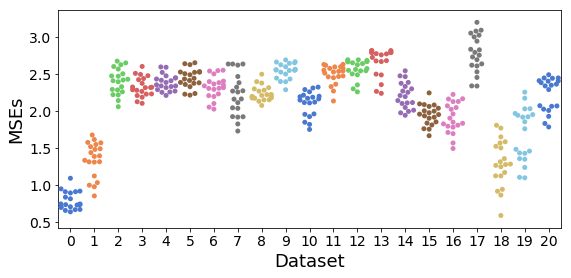

In [78]:
plotting.plt_mses_swarm(mses_M3_hog1, save_fig='')

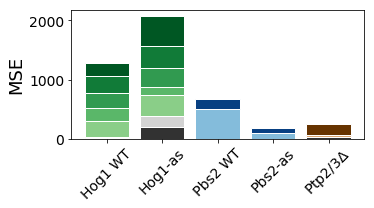

In [91]:
plotting.plt_mses(mses_M3_hog1, (1,1, 1, 1, 0,1), size=(5,3), ptpD=True ,save_fig=model_folder+sim_id+'fit_mses')

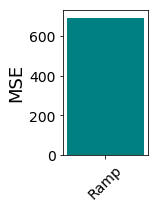

In [127]:
plotting.plt_mses(mses_M3_hog1, (0,0, 0, 0, 1, 0), size=(2,3), ptpD=True ,save_fig=model_folder+sim_id+'predicted_mses')

$- PTP$   $K_{M6}$    0.697593
$K_{M6}$  $- PTP$     0.697593
$s_1$     $K_{M5}$    0.745731
$K_{M5}$  $s_1$       0.745731
$K_{M4}$  $K_{M1}$    0.768664
$K_{M1}$  $K_{M4}$    0.768664
$k_6$     $- PTP$     0.917361
$- PTP$   $k_6$       0.917361
$s_1$     $- fb$      0.979722
$- fb$    $s_1$       0.979722
dtype: float64


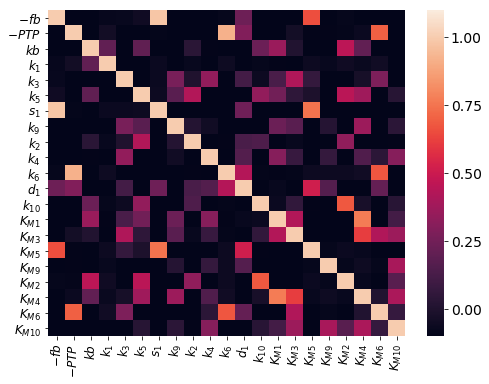

In [96]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [20]:
select_top_M3 = top_params_M3.copy()
select_top_M3 = select_top_M3[:10]

# M3c

In [ ]:
MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on

PTP = model_supp.molarity_conversion(118+400)


labelnames = ['$- fb$', '$+ fb$',  '$- PTP$','$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$', '$k_9$',
              '$k_2$', '$k_4$', '$k_6$','$d_1$', '$k_{10}$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$', '$K_{M9}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$', '$K_{M10}$']

minimums = [-4, -4, -4, -4,
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4]

maximums = [ 4, 4, 8, 4, 
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)

initials = [MAP3K, MAP2K, MAPK, gly, PTP]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]

mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly', 'PTP']

M3c_fxns = model.Model(model.M3c, model.simulate_t100a_experiment_M3c)


In [92]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191106_kb_M3c_long/'

gen = 2000
runs = 2000

model_folder = 'M3C/'
sim_id = 'M3C_f-all_'

idx_top_M3c, top_params_M3c, top, plt_top, new_params, params_from_file, mse_M3c, last_mses_M3c = model_supp.gather_simulated_data(folder, gen, runs, 0.1)
df_top_params_M3c = pd.DataFrame(top_params_M3c)
df_top_params_M3c.columns = labelnames
df_top_params_log = df_top_params_M3c.apply(np.log10)
df_top_params_log_M_M3c = df_top_params_log.loc[:50].melt(var_name='param', value_name='vals')

Number of runs collected: 1779
Best MSE: 3451.549590188612
Mean MSE of top 5%: 4430.954515879604


## Plot

No handles with labels found to put in legend.


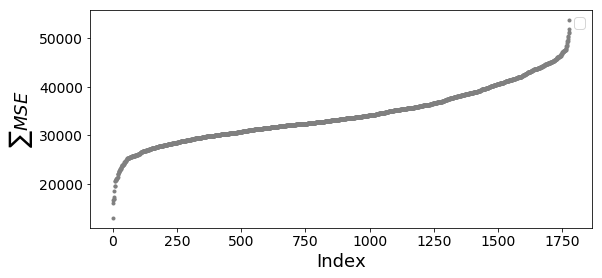

In [18]:
plotting.plt_idx_vs_mse(np.asarray(mse_M3c)[:,0], len(last_mses_M3c))

No handles with labels found to put in legend.


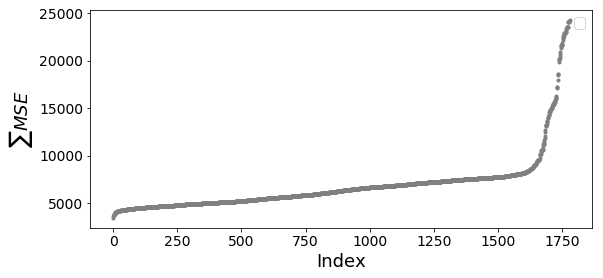

In [18]:
# top = 50
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,0], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,50], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,500], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,1000], len(last_mses_M4))
plotting.plt_idx_vs_mse(np.asarray(mse_M3c)[:,2000], len(last_mses_M3c))
# plotting.plt_idx_vs_mse(last_mses_M4, len(last_mses_M4))
plt.show()

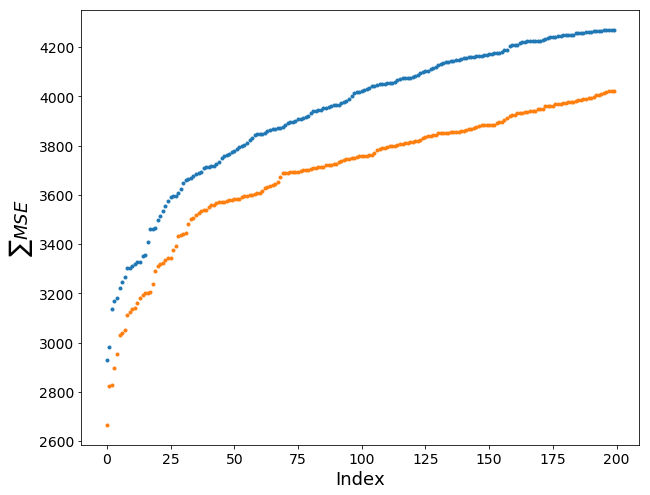

In [149]:
top = 200 # len(last_mses_M4)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,0], top)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,50], top)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,500], top)
plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,1000], top)
plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,2000], top)

(12.682625752136191, array([2], dtype=int64))

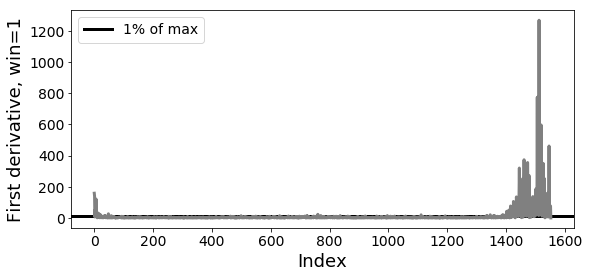

In [323]:
plotting.plt_deriv(last_mses_M3c,len(last_mses_M3c),len(last_mses_M3c),1,1)

[178]


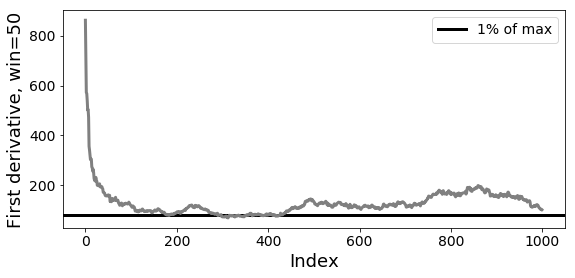

In [30]:
thresh_M3c, idx_thresh_M3c = plotting.plt_deriv(last_mses_M3c,1000,len(last_mses_M3c),1, 50)
# plt.ylim(0,10)
print(idx_thresh_M3c)

(0, 5)

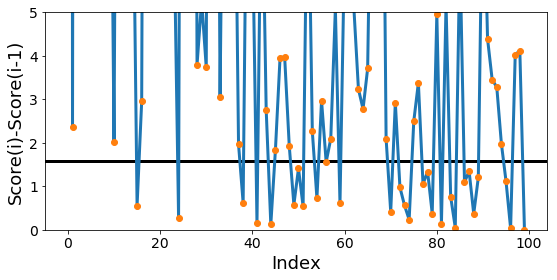

In [126]:
plotting.plt_deriv(last_mses_M4, 100,1)

# thresh = 158.38711511863949*0.01
# print(thresh)
# print(z)
# np.argwhere(z<thresh)
plt.ylim(0,5)

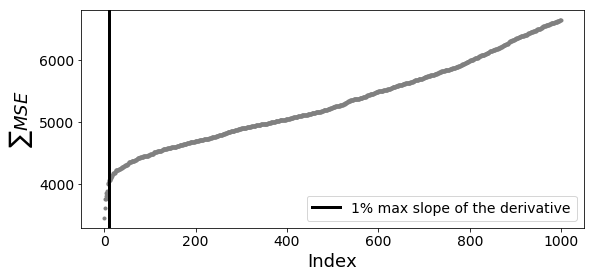

In [21]:
plotting.plt_idx_vs_mse(last_mses_M3c, 1000, idx_thresh_M3c)

In [50]:
select_top_M3c = top_params_M3c.copy()
select_top_M3c = np.concatenate((select_top_M3c[:4], select_top_M3c[6:12]))
# select_top_M4 = select_top_M4[:8]
# select_top_M4 = select_top_M4[:idx_thresh_M4[0]]
print(len(select_top_M3c))

10


[0.0, 1.4389279999999998, 0.0, 6.683727, 0.0, 1.5910793333333333, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.41533333333333333, 0.0, 2.292, 0.45100000000000007, 0.0, 0.0, 0.0]
[0.0, 87.56048333333335, 36.91355333333333, 9.777030333333334, 2.32173, 7.411622, 4.170973333333333, 4.559893333333333, 0.4476666666666667]
[0.5520593333333333, 96.95083, 91.2428, 42.60844, 7.138338, 7.598203000000001, 6.0144366666666675, 2.3502076666666665, 1.0706666666666667]
[0.6490203333333334, 100.0, 97.45942666666667, 89.93621999999999, 34.41316, 9.431778, 5.21595, 4.05654, 0.8378]
[0.944585, 100.0, 96.52539, 100.0, 76.78236, 17.346785666666666, 6.596584333333333, 5.280653333333333, 0.1745]
[1.6346319999999999, 100.0, 95.85280333333333, 100.0, 90.69620666666667, 58.423226666666665, 23.55539333333333, 15.694048, 1.4259598333333334]


<Figure size 720x576 with 0 Axes>

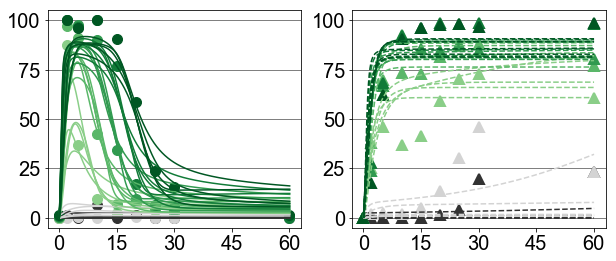

In [153]:
plotting.plt_param_behaviors(M3c_fxns, select_top_M3c, 5, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig = 'sdkhfhla')
# plotting.plt_param_behaviors(M4_fxns, select_top_M4, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')

# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

<Figure size 720x576 with 0 Axes>

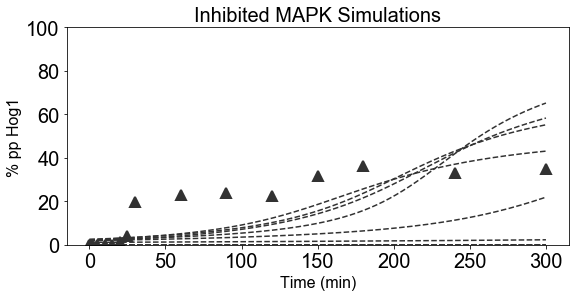

In [154]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M3c_fxns, select_top_M3c, idx_thresh_M3c[0], params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)
# plotting.plt_t100a_long(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

[69.21298533333334, 70.43929433333334, 69.13075466666666, 70.10919266666667, 71.83607400000001, 68.500545, 70.39754866666667, 67.13918633333333, 65.29440766666667]
[67.96815333333335, 72.17003666666666, 81.88531, 79.82825666666668, 75.30463333333333, 72.21497000000001, 71.48254666666666, 72.27067333333332, 71.33024666666667]
[60.97395666666667, 98.04499666666668, 97.95799666666666, 93.63105, 85.58830999999999, 81.89701000000001, 77.64276666666666, 70.95659333333333, 66.28683666666666]


<Figure size 720x576 with 0 Axes>

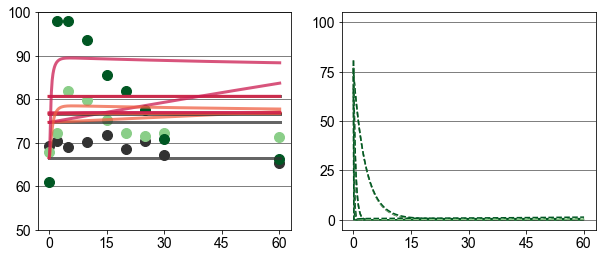

In [155]:
# plotting.plt_param_behaviors(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True, save_fig=model_folder+sim_id+'ptp23D')
plotting.plt_param_behaviors(M3c_fxns, select_top_M3c, 5, params_constants, initials, [0,150000, 550000], time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True) # [0]+map2k_doses

[6.376494999999999, 39.40436, 18.11695, 9.327703999999999, 9.214675999999999, 8.679822, 9.319789, 8.838417, 8.249728999999999]
[4.174140155, 60.86042109000001, 66.40960150000001, 54.85086178, 31.06532193, 8.856769223999999, 5.202683468, 5.677920521, 6.455600497000002]


<Figure size 720x576 with 0 Axes>

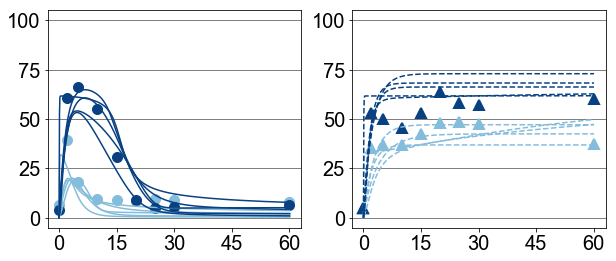

In [158]:
plotting.plt_param_behaviors(M3c_fxns, select_top_M3c, 5, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig='2sdfs')
# plotting.plt_param_behaviors(M4_fxns, select_top_M4, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

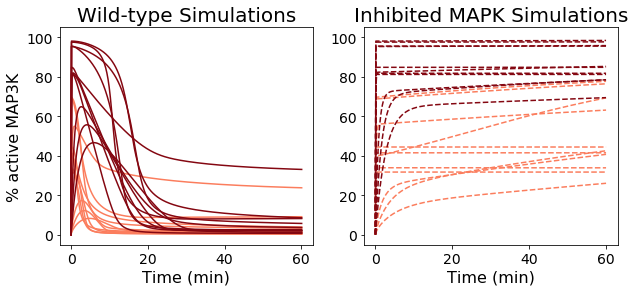

In [28]:
plotting.plt_param_behaviors(M3c_fxns, select_top_M3c, idx_thresh_M3c[0], params_constants, initials,  map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

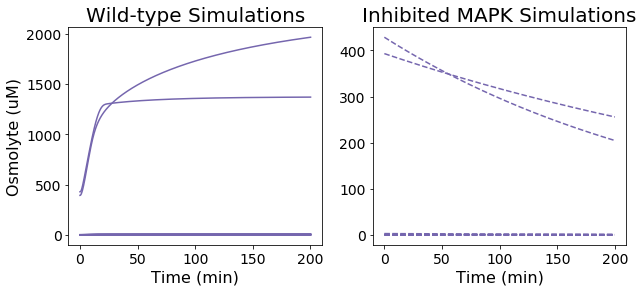

In [343]:
plotting.plt_param_behaviors(M3c_fxns, select_top_M3c, idx_thresh_M3c[0], params_constants, initials,  [350000], time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


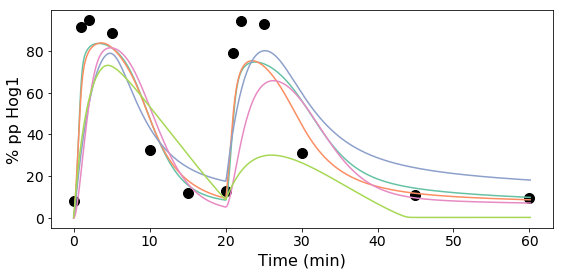

In [345]:
plotting.plt_ramp_behaviors(M3c_fxns, select_top_M3c, 5, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

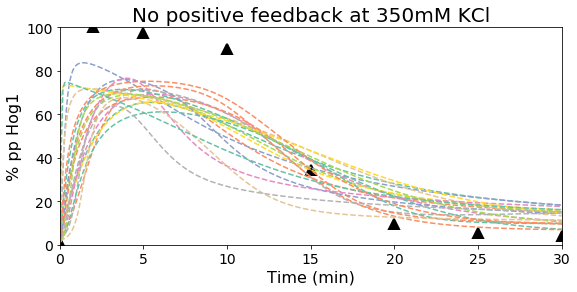

In [203]:
plotting.plt_nopos(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, mapk_wt_data[4], mapk_time, 350000, save_fig='')

<Figure size 720x576 with 0 Axes>

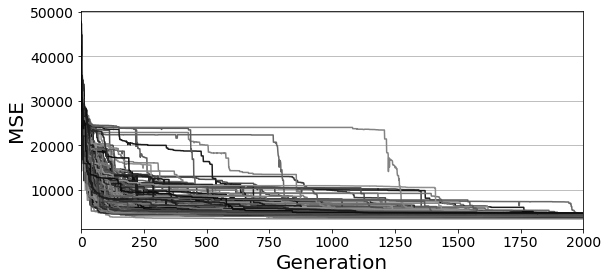

In [351]:
plotting.plt_mses_gen(gen,mse_M3c, idx_top_M3c)

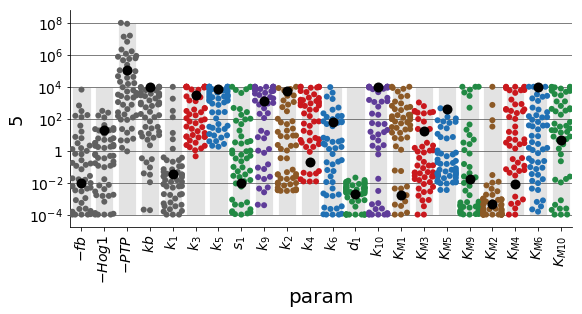

In [95]:
plotting.plt_param_ranges(labelnames, 'M3c', dims, df_top_params_log_M_M3c, df_top_params_log, num = 5)

In [218]:
mses_M4 = model_supp.get_mse_stats(M4_fxns, top_params_M4, params_constants, initials, ptpD=True)
mses_M4.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0           1           2           3          4          5   \
0   7.751272   43.879614  100.606595   30.631718  40.551681  54.754887   
1  31.275403  100.336418  611.831113  157.485672  32.406413  53.628781   
2   5.927604   31.603911   18.868150   63.039652  47.466493  44.527748   
3   4.394082   16.387757  163.053559   28.742180  13.721493  18.064514   
4   8.104043   36.506925  126.521394   29.294387  34.898427  59.563664   

          6           7           8           9      ...              11  \
0  30.096783  214.047362  147.408087   89.340410     ...      101.222636   
1  25.223350  108.111837  157.139202   94.480570     ...       78.443042   
2  23.198922  125.876125  164.407567  180.899002     ...      497.603896   
3  42.869904  235.573405  181.311337  203.583074     ...      130.488343   
4  32.890033  114.940044  169.467476  111.406833     ...      239.687293   

           12          13          14          15          16          17  \
0  152.428333  242.529492  328.785602  106.596456  110.716609  184.765544   
1  130.109908  225.394470  135.227608   95.359313  139.256963  799.777799   
2  244.997359  306.203962  133.911183   62.220222   64.683864  238.240835   
3  257.527168  342.534594  337.602015   96.879755   62.909910  458.682582   
4  403.652542  512.114209  275.776149  106.172575   34.065415  227.209913   

          18          19          20  
0  31.285075  471.919714  155.893627  
1   9.304547  358.208733  178.959975  
2  14.895255  347.102122  139.466367  
3   4.442658  418.392962  148.597600  
4  24.457555  208.639678  170.130686  

[5 rows x 21 columns]

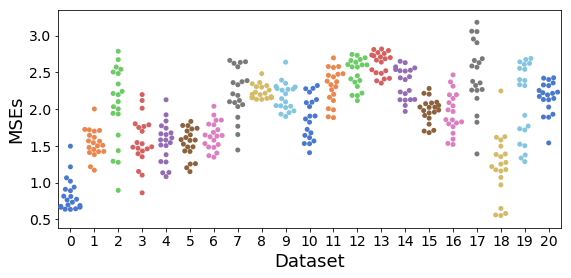

In [219]:
plotting.plt_mses_swarm(mses_M4, save_fig='')

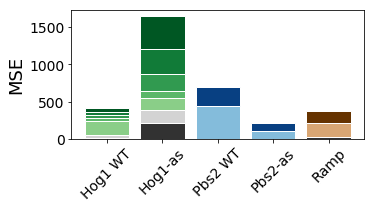

In [220]:
plotting.plt_mses(mses_M4, (1,1, 1, 1, 0,1), size=(5,3), ptpD=True ,save_fig=model_folder+sim_id+'fit_mses')

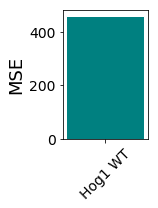

In [221]:
plotting.plt_mses(mses_M4, (0,0, 0, 0, 1, 0), size=(2,3), ptpD=True ,save_fig=model_folder+sim_id+'predicted_mses')

$k_6$     $k_{10}$    0.632830
$k_{10}$  $k_6$       0.632830
$K_{M9}$  $k_9$       0.646356
$k_9$     $K_{M9}$    0.646356
$k_2$     $K_{M9}$    0.686548
$K_{M9}$  $k_2$       0.686548
$K_{M3}$  $k_2$       0.719001
$k_2$     $K_{M3}$    0.719001
$k_4$     $K_{M4}$    0.915897
$K_{M4}$  $k_4$       0.915897
dtype: float64


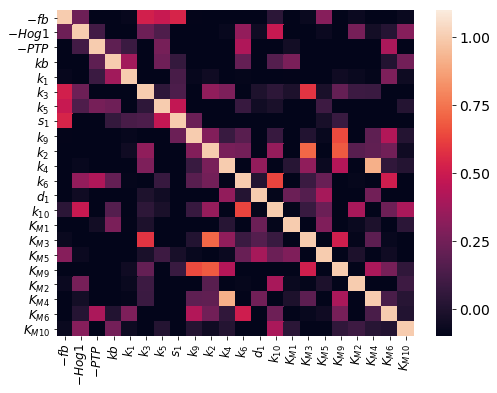

In [222]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

# M4

## Model Constant Params

In [118]:

MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on

PTP = model_supp.molarity_conversion(118+400)



# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['$- fb$', '$- Hog1$','$- PTP$','$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$', '$k_9$',
              '$k_2$', '$k_4$', '$k_6$','$d_1$', '$k_{10}$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$', '$K_{M9}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$', '$K_{M10}$']

minimums = [-4, -4, -4, -4, 
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4]

maximums = [ 4,  4, 8, 4, 
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, gly, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 


# doses = [0, 50, 150, 250, 350, 450, 550]
# map2k_doses = [150, 550]

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]

mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly', 'PTP']

M4_fxns = model.Model(model.M4, model.simulate_t100a_experiment_M4, model.simulate_nopos_experiment_M4)

if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


##  190923_kb_M4_long.zip


**Notes** 
- M4 model - mutual inhibition model, though i named the files M3. 

### Gather simulated data

In [123]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190926_kb_M4_long/'

gen = 2000
runs = 2000

model_folder = 'M4/'
sim_id = 'M4_f-all_'

idx_top_M4, top_params_M4, top, plt_top, new_params, params_from_file, mse_M4, last_mses_M4 = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params_M4 = pd.DataFrame(top_params_M4)
df_top_params_M4.columns = labelnames
df_top_params_log = df_top_params_M4.apply(np.log10)
df_top_params_log_M_M4 = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1753
Best MSE: 2665.709966122509
Mean MSE of top 5%: 3074.0871365281923


### Plot

#### threshold

No handles with labels found to put in legend.


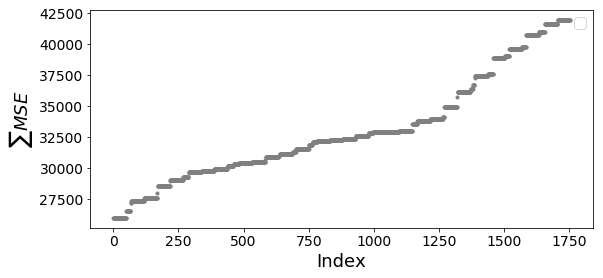

In [280]:
plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,0], len(last_mses_M4))

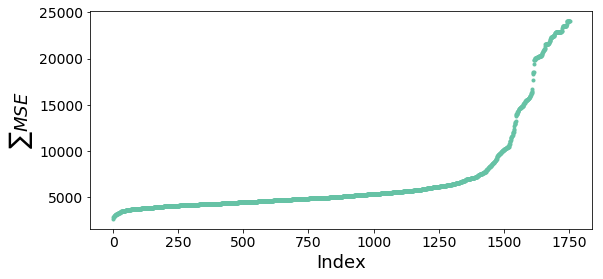

In [176]:
# top = 50
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,0], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,50], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,500], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,1000], len(last_mses_M4))
plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,2000], len(last_mses_M4))
# plotting.plt_idx_vs_mse(last_mses_M4, len(last_mses_M4))
plt.show()

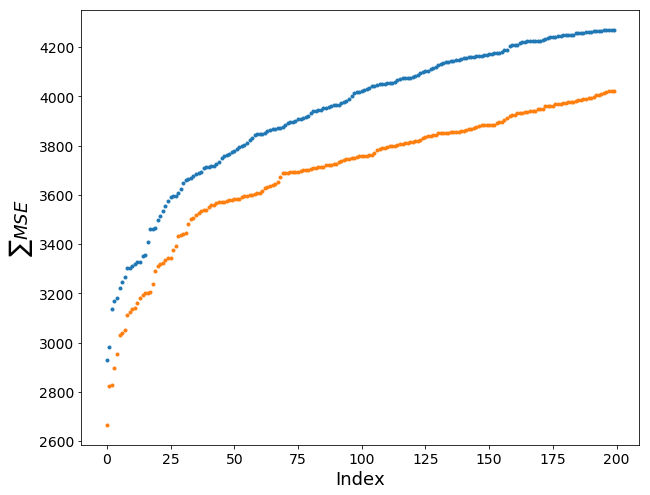

In [149]:
top = 200 # len(last_mses_M4)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,0], top)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,50], top)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,500], top)
plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,1000], top)
plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,2000], top)

(9.495197608529233, array([1], dtype=int64))

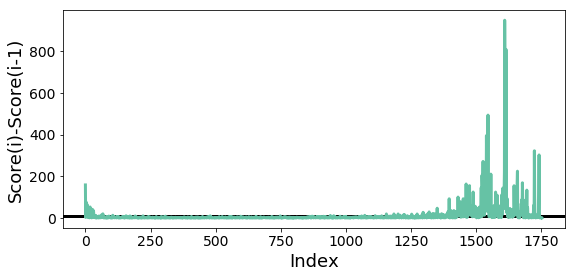

In [177]:
plotting.plt_deriv(last_mses_M4,len(last_mses_M4),1)

[15]


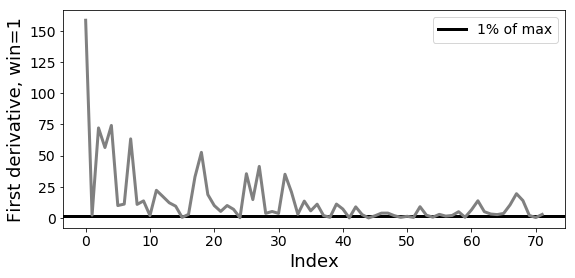

In [66]:
thresh_M4, idx_thresh_M4 = plotting.plt_deriv(last_mses_M4, 72, 1000, 1, 1)
# plt.ylim(0,10)
print(idx_thresh_M4)

(0, 5)

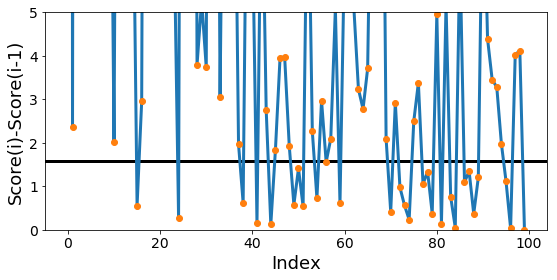

In [126]:
plotting.plt_deriv(last_mses_M4, 100,1)

# thresh = 158.38711511863949*0.01
# print(thresh)
# print(z)
# np.argwhere(z<thresh)
plt.ylim(0,5)

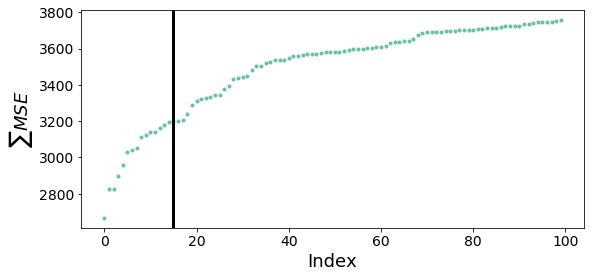

In [253]:
plotting.plt_idx_vs_mse(last_mses_M4, 100, idx_thresh_M4)

In [67]:
select_top_M4 = top_params_M4.copy()
# select_top_M4 = np.concatenate((select_top_M4[:7], select_top_M4[8:11]))
# select_top_M4 = select_top_M4[:8]
select_top_M4 = select_top_M4[:idx_thresh_M4[0]]
print(len(select_top_M4))

15


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

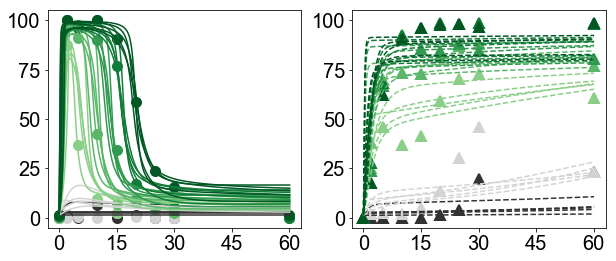

In [98]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4, 5, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig='M4_talk_fits_hog1')
# plotting.plt_param_behaviors(M4_fxns, select_top_M4, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')

# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

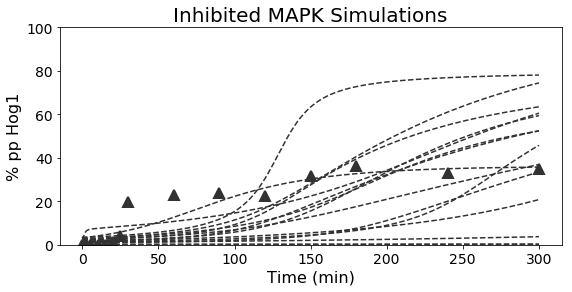

In [252]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)
# plotting.plt_t100a_long(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

[69.21298533333334, 70.43929433333334, 69.13075466666666, 70.10919266666667, 71.83607400000001, 68.500545, 70.39754866666667, 67.13918633333333, 65.29440766666667]
[67.96815333333335, 72.17003666666666, 81.88531, 79.82825666666668, 75.30463333333333, 72.21497000000001, 71.48254666666666, 72.27067333333332, 71.33024666666667]
[60.97395666666667, 98.04499666666668, 97.95799666666666, 93.63105, 85.58830999999999, 81.89701000000001, 77.64276666666666, 70.95659333333333, 66.28683666666666]
[68.71881, 99.52960666666667, 99.53548666666667, 98.80353333333333, 94.73540666666668, 89.76684333333333, 85.48934000000001, 82.57793666666667, 71.67305333333333]


<Figure size 720x576 with 0 Axes>

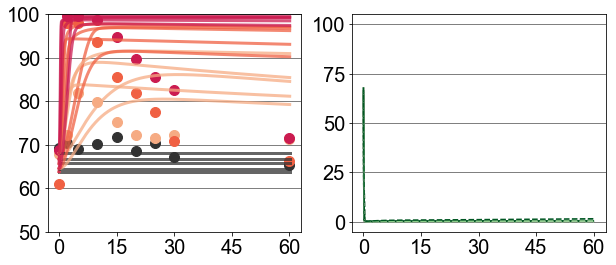

In [151]:
# plotting.plt_param_behaviors(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True, save_fig=model_folder+sim_id+'ptp23D')
plotting.plt_param_behaviors(M4_fxns, select_top_M4, 5, params_constants, initials, [0, 50000, 150000, 550000], time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True, save_fig='ototooot') # [0]+map2k_doses

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

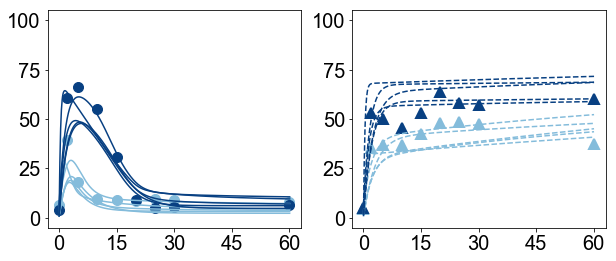

In [99]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4, 5, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig='Pbs2_m4')
# plotting.plt_param_behaviors(M4_fxns, select_top_M4, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

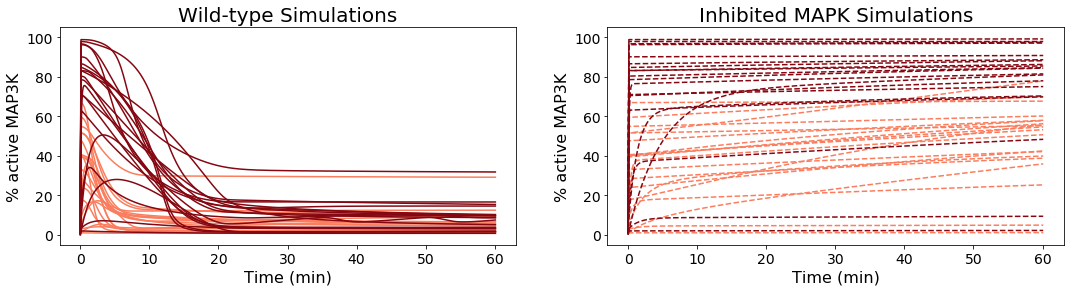

In [186]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

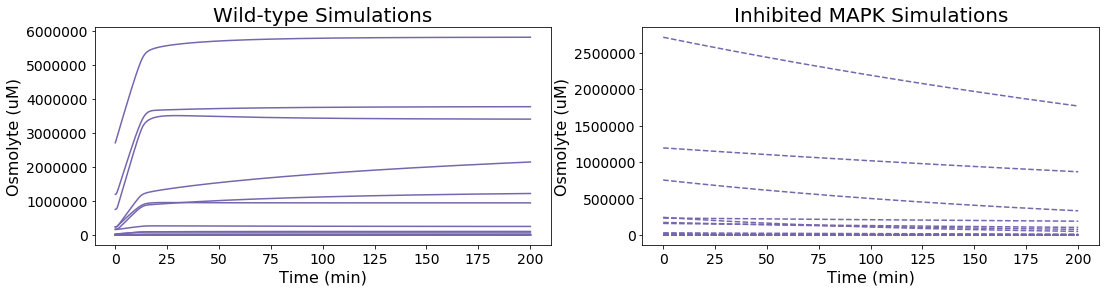

In [187]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


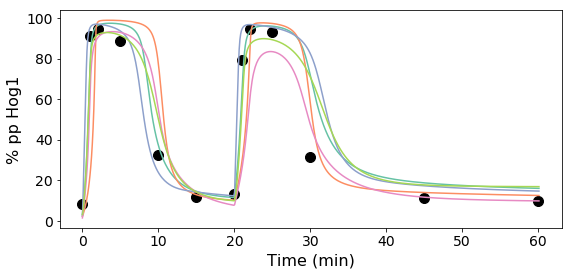

In [262]:
plotting.plt_ramp_behaviors(M4_fxns, select_top_M4, 5, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

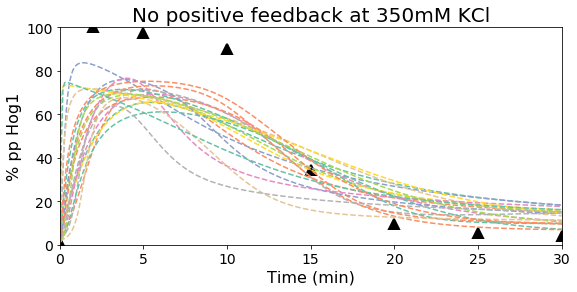

In [203]:
plotting.plt_nopos(M4_fxns, select_top_M4, idx_thresh_M4[0], params_constants, initials, mapk_wt_data[4], mapk_time, 350000, save_fig='')

In [ ]:
ptpD_total_protein = [MAP3K_t, MAP2K_t, MAPK_t, 550000*2, 0]
ptpD_inits = [MAP3K, MAP2K, MAPK, gly, 0]

<Figure size 432x288 with 0 Axes>

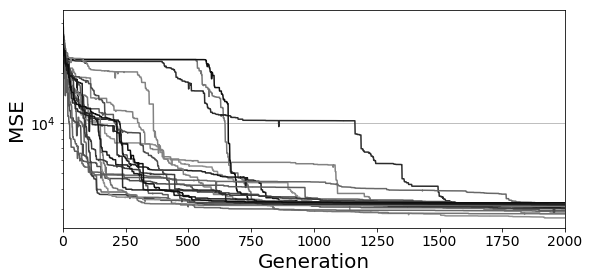

In [216]:
plotting.plt_mses_gen(gen,mse_M4, idx_top_M4, save_fig=model_folder+sim_id+'mses')

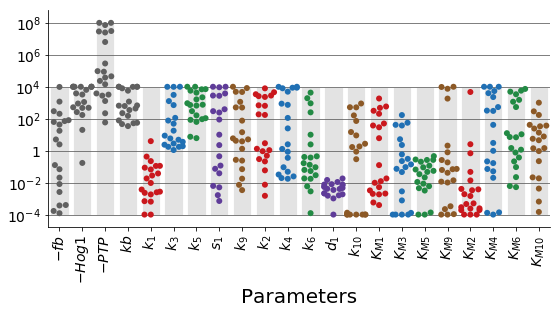

In [217]:
plotting.plt_param_ranges(labelnames, 'M4', dims, df_top_params_log_M_M4, save_fig=model_folder+sim_id+'params')

In [218]:
mses_M4 = model_supp.get_mse_stats(M4_fxns, top_params_M4, params_constants, initials, ptpD=True)
mses_M4.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0           1           2           3          4          5   \
0   7.751272   43.879614  100.606595   30.631718  40.551681  54.754887   
1  31.275403  100.336418  611.831113  157.485672  32.406413  53.628781   
2   5.927604   31.603911   18.868150   63.039652  47.466493  44.527748   
3   4.394082   16.387757  163.053559   28.742180  13.721493  18.064514   
4   8.104043   36.506925  126.521394   29.294387  34.898427  59.563664   

          6           7           8           9      ...              11  \
0  30.096783  214.047362  147.408087   89.340410     ...      101.222636   
1  25.223350  108.111837  157.139202   94.480570     ...       78.443042   
2  23.198922  125.876125  164.407567  180.899002     ...      497.603896   
3  42.869904  235.573405  181.311337  203.583074     ...      130.488343   
4  32.890033  114.940044  169.467476  111.406833     ...      239.687293   

           12          13          14          15          16          17  \
0  152.428333  242.529492  328.785602  106.596456  110.716609  184.765544   
1  130.109908  225.394470  135.227608   95.359313  139.256963  799.777799   
2  244.997359  306.203962  133.911183   62.220222   64.683864  238.240835   
3  257.527168  342.534594  337.602015   96.879755   62.909910  458.682582   
4  403.652542  512.114209  275.776149  106.172575   34.065415  227.209913   

          18          19          20  
0  31.285075  471.919714  155.893627  
1   9.304547  358.208733  178.959975  
2  14.895255  347.102122  139.466367  
3   4.442658  418.392962  148.597600  
4  24.457555  208.639678  170.130686  

[5 rows x 21 columns]

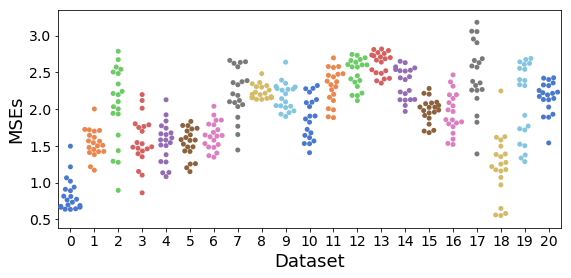

In [219]:
plotting.plt_mses_swarm(mses_M4, save_fig='')

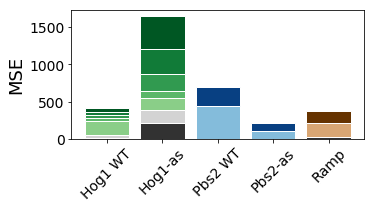

In [220]:
plotting.plt_mses(mses_M4, (1,1, 1, 1, 0,1), size=(5,3), ptpD=True ,save_fig=model_folder+sim_id+'fit_mses')

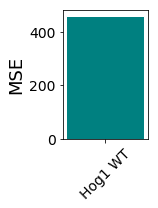

In [221]:
plotting.plt_mses(mses_M4, (0,0, 0, 0, 1, 0), size=(2,3), ptpD=True ,save_fig=model_folder+sim_id+'predicted_mses')

$k_6$     $k_{10}$    0.632830
$k_{10}$  $k_6$       0.632830
$K_{M9}$  $k_9$       0.646356
$k_9$     $K_{M9}$    0.646356
$k_2$     $K_{M9}$    0.686548
$K_{M9}$  $k_2$       0.686548
$K_{M3}$  $k_2$       0.719001
$k_2$     $K_{M3}$    0.719001
$k_4$     $K_{M4}$    0.915897
$K_{M4}$  $k_4$       0.915897
dtype: float64


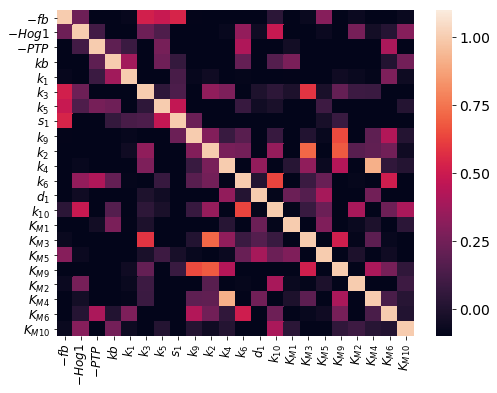

In [222]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data for GraphPad

In [141]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_wt')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##  191014_kb_M4_ptp23D.py


**Notes** 
- M4 model - mutual inhibition model, fit to just the ptp23D data

### Gather simulated data

In [277]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191014_kb_M4_ptp23D/'
gen = 1000
runs = 2000

model_folder = 'M4/'
sim_id = 'M4_f-ptp23D_'

if len(labelnames) == len(diff):
    print('Params and labels match')

idx_top_M4_ptp23D, top_params_M4_ptp23D, top, plt_top, new_params, params_from_file, mse_M4_ptp23D, last_mses_M4_ptp23D = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params_ptp23D = pd.DataFrame(top_params_M4_ptp23D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params_ptp23D.apply(np.log10)
df_top_params_log_M_M4_ptp23D = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 2498
Best MSE: 8.787114130792315
Mean MSE of top 5%: 19.467082512575466


### Plot

In [269]:
select_top_M4_ptp23D = top_params_M4_ptp23D.copy()
# select_top_M4 = np.concatenate((select_top_M4[:8], select_top_M4[9:11]))
# select_top_M4 = select_top_M4[:8]

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

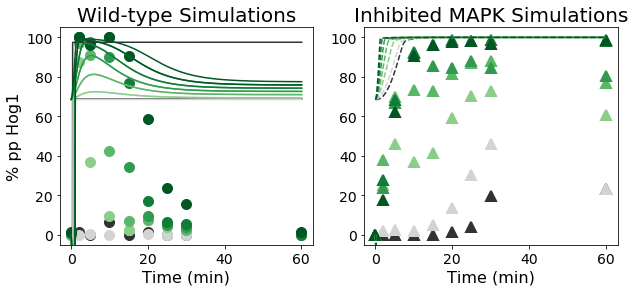

In [271]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 2, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

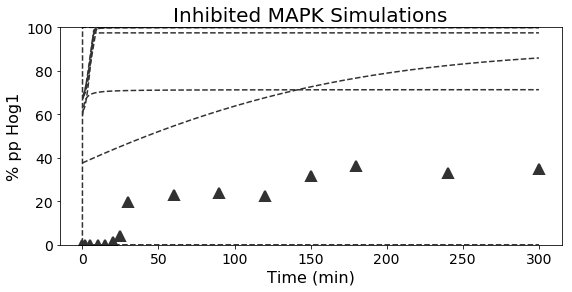

In [273]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

In [144]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True, save_fig=model_folder+sim_id+'ptp23D')

NameError: name 'select_top_M4_ptp23D' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

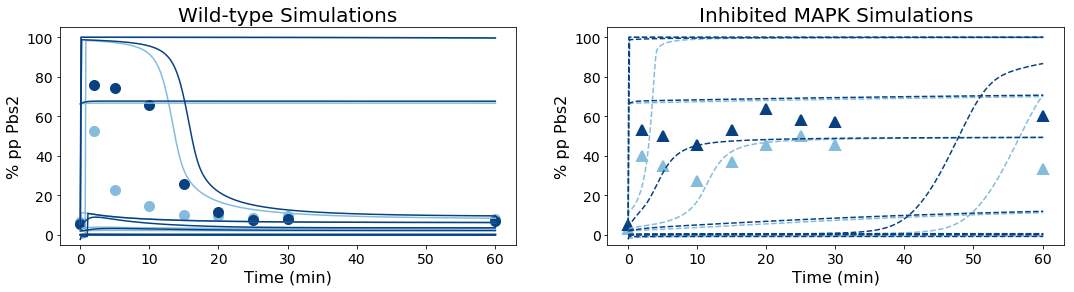

In [175]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

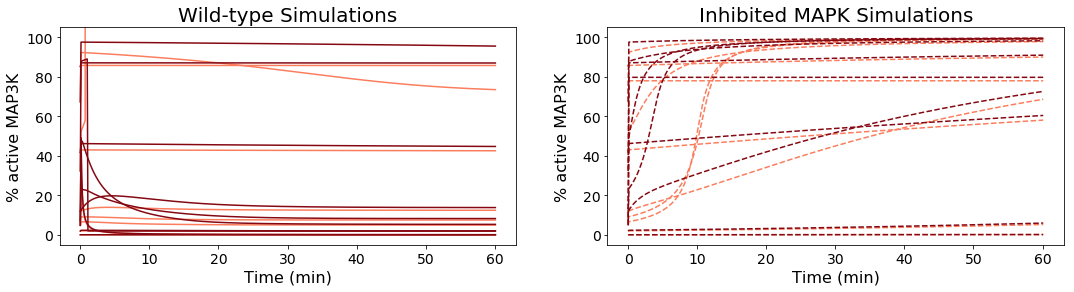

In [176]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

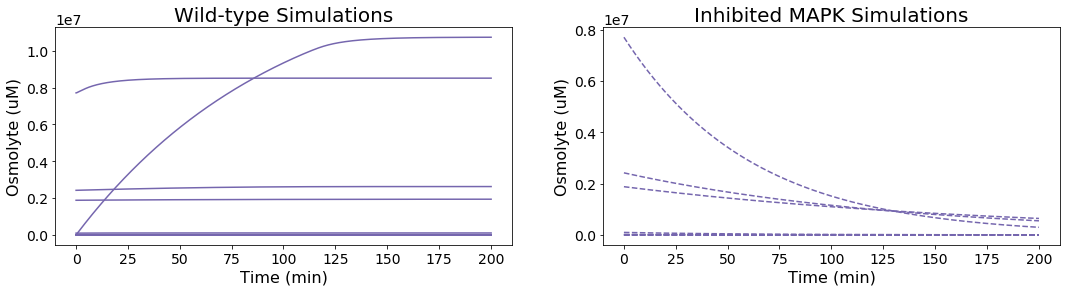

In [177]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


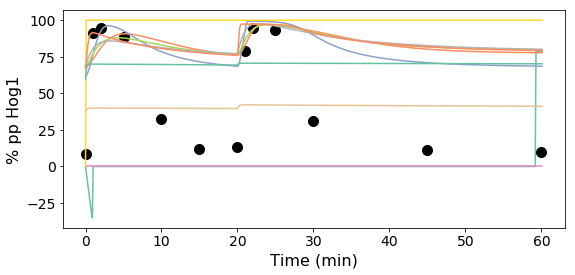

In [178]:
plotting.plt_ramp_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 432x288 with 0 Axes>

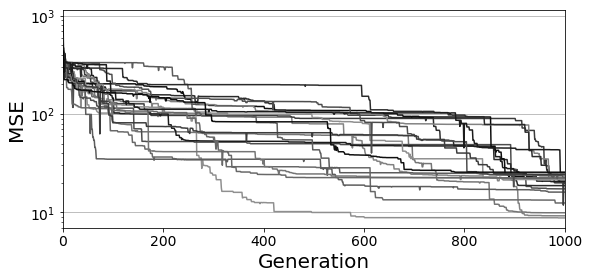

In [180]:
plotting.plt_mses_gen(gen,mse_M4_ptp23D, idx_top_M4_ptp23D, save_fig=model_folder+sim_id+'mses')

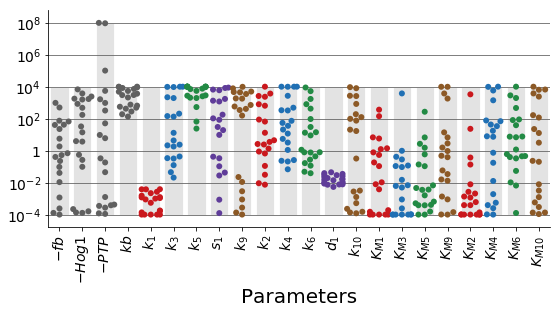

In [274]:
plotting.plt_param_ranges(labelnames, 'M4', dims, df_top_params_log_M_M4_ptp23D, save_fig=model_folder+sim_id+'params')

In [188]:
mses_M4_ptp23D = model_supp.get_mse_stats(M4_fxns, top_params_M4_ptp23D, params_constants, initials, ptpD=True)
mses_M4_ptp23D.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0            1            2            3            4   \
0  6896.869627  7445.987199  5278.969671  5920.526884  4211.967416   
1  4552.752568  4899.598040  3927.508427  3502.320141  3093.064788   
2  3693.547009  4052.483584  3192.318034  2748.426021  2411.941367   
3     5.458695     0.620215  1024.603020  2187.570423  3211.071163   
4  4517.836006  4880.083935  3882.629722  3500.486074  3127.122549   

            5            6             7             8             9   \
0  4525.259289  3187.755952  61941.288919  59316.857030  70956.698771   
1  2868.395339  2165.001277   6449.760823   6290.843890   2485.209867   
2  2237.007879  1647.235776   6338.363097   6214.316450   2467.655788   
3  3953.302019  4625.021468    441.459250    419.964424   2581.587883   
4  2895.551638  2180.180899   6489.599634   6347.901492   2520.372690   

     ...               11            12            13           14  \
0    ...     81129.525765  85600.374487  84327.791708  1832.231454   
1    ...      1337.595803   1212.542449   1440.181888  1442.209447   
2    ...      1330.936050   1127.254364   1350.450701  1832.846064   
3    ...      5476.191007   6864.178241   6635.917545  2175.688628   
4    ...      1332.098312   1192.817428   1429.782470  1662.689797   

            15           16            17        18        19        20  
0  1470.701156  2803.704206  8.420205e+09  2.838332  4.046178  1.902604  
1   275.304471   278.213976  2.214370e+03  3.764429  1.354367  4.109785  
2  1380.689719  2670.131411  1.739575e+03  4.225390  3.071769  2.618865  
3  1225.167675   609.882607  3.974040e+03  3.827279  4.495342  4.144051  
4  1052.040717  2101.323228  2.204861e+03  4.141035  5.055792  6.882604  

[5 rows x 21 columns]

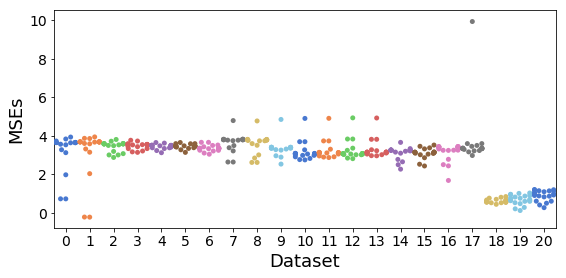

In [189]:
plotting.plt_mses_swarm(mses_M4_ptp23D, save_fig='')

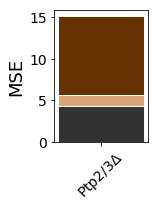

In [191]:
plotting.plt_mses(mses_M4_ptp23D, (0,0, 0, 0, 0,1), size=(2,3), ptpD=True ,save_fig=model_folder+sim_id+'fit_mses')

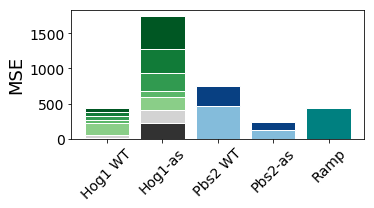

In [193]:
plotting.plt_mses(mses_M4, (1,1, 1, 1, 1, 0), size=(5,3), ptpD=True ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M3}$  $k_{10}$    0.710191
$k_{10}$  $K_{M3}$    0.710191
$K_{M6}$  $k_6$       0.842994
$k_6$     $K_{M6}$    0.842994
$kb$      $k_1$       0.873757
$k_1$     $kb$        0.873757
$K_{M3}$  $- fb$      0.883064
$- fb$    $K_{M3}$    0.883064
$k_2$     $K_{M2}$    0.894560
$K_{M2}$  $k_2$       0.894560
dtype: float64


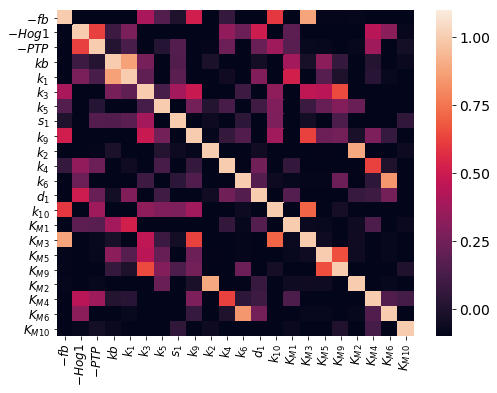

In [303]:
plotting.plt_corr(labelnames, df_top_params_ptp23D)

In [141]:
save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_wt')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##  191115_kb_M4.py


**Notes** 
- M4 model - mutual inhibition model, fit to just the ptp23D data

### Gather simulated data

In [107]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191115_kb_M4/'
gen = 1000
runs = 2000

model_folder = './'
sim_id = 'M4_f-newPTP_'

if len(labelnames) == len(diff):
    print('Params and labels match')

M4_fxns = model.Model(model.M4_new, model.simulate_t100a_experiment_M4, model.simulate_nopos_experiment_M4)    
    
idx_top_M4_new, top_params_M4_new, top, plt_top, new_params, params_from_file, mse_M4_new, last_mses_M4_new = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params_new = pd.DataFrame(top_params_M4_new)
df_top_params_new.columns = labelnames
df_top_params_log = df_top_params_new.apply(np.log10)
df_top_params_log_M_M4_new= df_top_params_log.melt(var_name='param', value_name='vals')

Params and labels match
Number of runs collected: 1057
Best MSE: 3175.2769139409165
Mean MSE of top 5%: 3525.6738902438483


### Plot

In [102]:
select_top_M4_new = top_params_M4_new.copy()
# select_top_M4 = np.concatenate((select_top_M4[:8], select_top_M4[9:11]))
# select_top_M4 = select_top_M4[:8]

<Figure size 720x576 with 0 Axes>

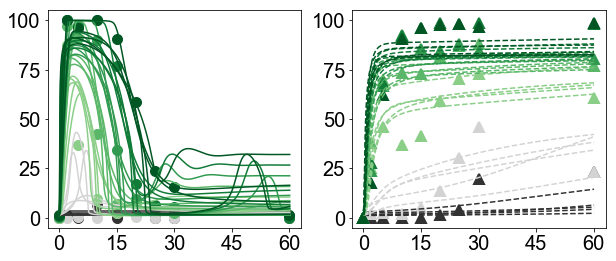

In [110]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_new, 5, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

<Figure size 720x576 with 0 Axes>

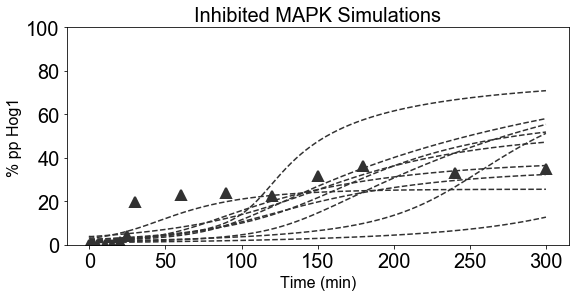

In [111]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M4_fxns, select_top_M4_new, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

[69.21298533333334, 70.43929433333334, 69.13075466666666, 70.10919266666667, 71.83607400000001, 68.500545, 70.39754866666667, 67.13918633333333, 65.29440766666667]
[67.96815333333335, 72.17003666666666, 81.88531, 79.82825666666668, 75.30463333333333, 72.21497000000001, 71.48254666666666, 72.27067333333332, 71.33024666666667]
[60.97395666666667, 98.04499666666668, 97.95799666666666, 93.63105, 85.58830999999999, 81.89701000000001, 77.64276666666666, 70.95659333333333, 66.28683666666666]


<Figure size 720x576 with 0 Axes>

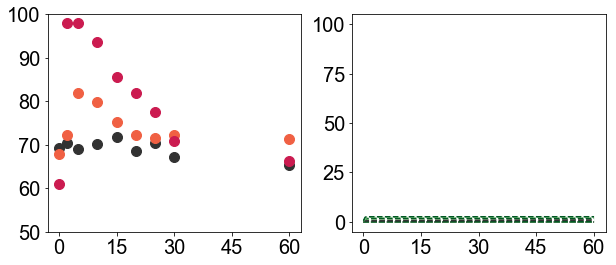

In [143]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_new, 5, params_constants, initials, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time, ptp23D=True, save_fig=model_folder+sim_id+'ptp23D')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

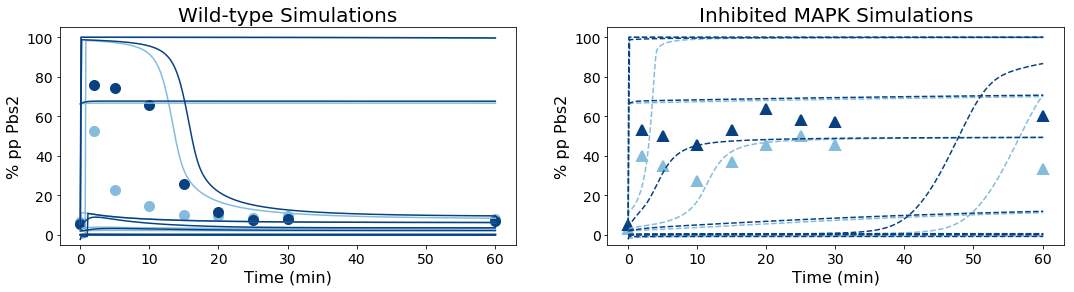

In [175]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

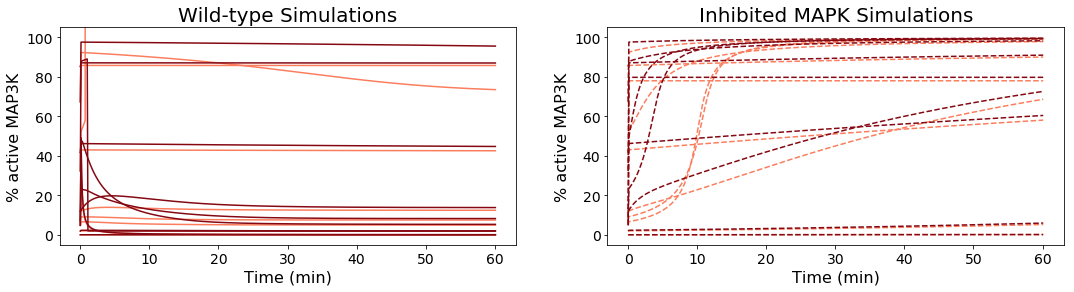

In [176]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

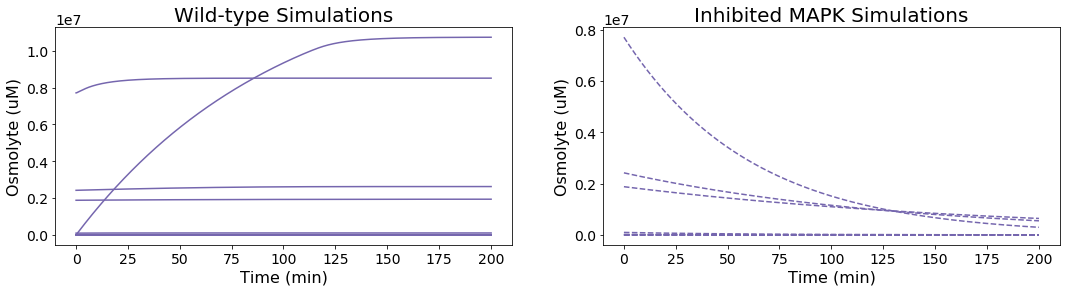

In [177]:
plotting.plt_param_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


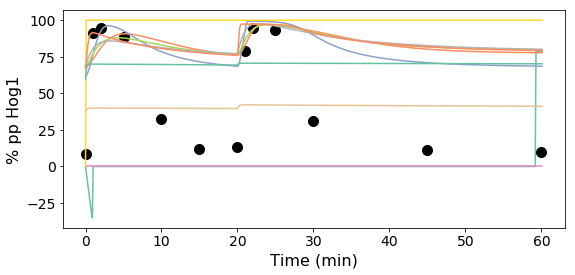

In [178]:
plotting.plt_ramp_behaviors(M4_fxns, select_top_M4_ptp23D, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 432x288 with 0 Axes>

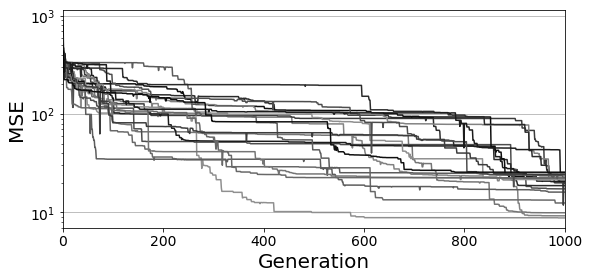

In [180]:
plotting.plt_mses_gen(gen,mse_M4_ptp23D, idx_top_M4_ptp23D, save_fig=model_folder+sim_id+'mses')

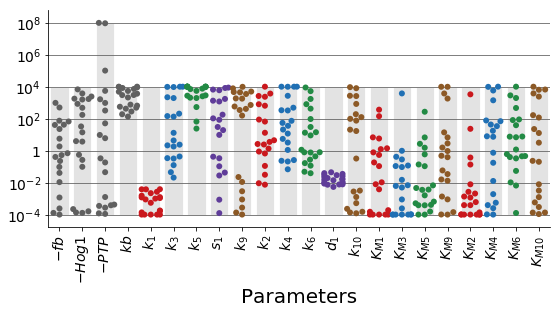

In [274]:
plotting.plt_param_ranges(labelnames, 'M4', dims, df_top_params_log_M_M4_ptp23D, save_fig=model_folder+sim_id+'params')

In [188]:
mses_M4_ptp23D = model_supp.get_mse_stats(M4_fxns, top_params_M4_ptp23D, params_constants, initials, ptpD=True)
mses_M4_ptp23D.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0            1            2            3            4   \
0  6896.869627  7445.987199  5278.969671  5920.526884  4211.967416   
1  4552.752568  4899.598040  3927.508427  3502.320141  3093.064788   
2  3693.547009  4052.483584  3192.318034  2748.426021  2411.941367   
3     5.458695     0.620215  1024.603020  2187.570423  3211.071163   
4  4517.836006  4880.083935  3882.629722  3500.486074  3127.122549   

            5            6             7             8             9   \
0  4525.259289  3187.755952  61941.288919  59316.857030  70956.698771   
1  2868.395339  2165.001277   6449.760823   6290.843890   2485.209867   
2  2237.007879  1647.235776   6338.363097   6214.316450   2467.655788   
3  3953.302019  4625.021468    441.459250    419.964424   2581.587883   
4  2895.551638  2180.180899   6489.599634   6347.901492   2520.372690   

     ...               11            12            13           14  \
0    ...     81129.525765  85600.374487  84327.791708  1832.231454   
1    ...      1337.595803   1212.542449   1440.181888  1442.209447   
2    ...      1330.936050   1127.254364   1350.450701  1832.846064   
3    ...      5476.191007   6864.178241   6635.917545  2175.688628   
4    ...      1332.098312   1192.817428   1429.782470  1662.689797   

            15           16            17        18        19        20  
0  1470.701156  2803.704206  8.420205e+09  2.838332  4.046178  1.902604  
1   275.304471   278.213976  2.214370e+03  3.764429  1.354367  4.109785  
2  1380.689719  2670.131411  1.739575e+03  4.225390  3.071769  2.618865  
3  1225.167675   609.882607  3.974040e+03  3.827279  4.495342  4.144051  
4  1052.040717  2101.323228  2.204861e+03  4.141035  5.055792  6.882604  

[5 rows x 21 columns]

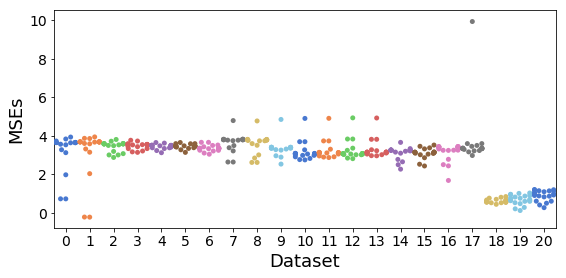

In [189]:
plotting.plt_mses_swarm(mses_M4_ptp23D, save_fig='')

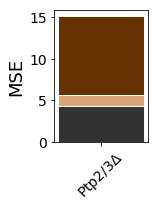

In [191]:
plotting.plt_mses(mses_M4_ptp23D, (0,0, 0, 0, 0,1), size=(2,3), ptpD=True ,save_fig=model_folder+sim_id+'fit_mses')

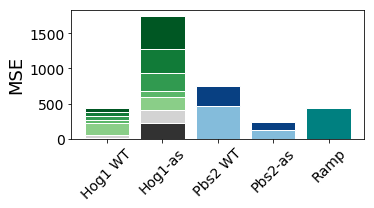

In [193]:
plotting.plt_mses(mses_M4, (1,1, 1, 1, 1, 0), size=(5,3), ptpD=True ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M3}$  $k_{10}$    0.710191
$k_{10}$  $K_{M3}$    0.710191
$K_{M6}$  $k_6$       0.842994
$k_6$     $K_{M6}$    0.842994
$kb$      $k_1$       0.873757
$k_1$     $kb$        0.873757
$K_{M3}$  $- fb$      0.883064
$- fb$    $K_{M3}$    0.883064
$k_2$     $K_{M2}$    0.894560
$K_{M2}$  $k_2$       0.894560
dtype: float64


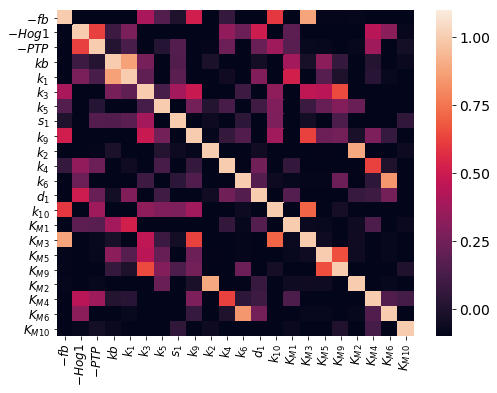

In [303]:
plotting.plt_corr(labelnames, df_top_params_ptp23D)

In [141]:
save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_wt')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# Compare Models

In [40]:
def change_param(param_set, idx):
    param_sets = []
#     print(param_set[idx])
    for i in np.logspace(-4,4,8):
        new_param_set = param_set.copy()
#         print(i)
#         print(new_param_set[idx])
        new_param_set[idx] = new_param_set[idx]*i
#         print(new_param_set[idx])
        param_sets.append(new_param_set)
    return param_sets

In [165]:
b3 = change_param(best_fit, 0)
a1 = change_param(best_fit, 1)
a2 = change_param(best_fit, 2)
kb = change_param(best_fit, 3)
k1 = change_param(best_fit, 4)
k3 = change_param(best_fit, 5)
k5 = change_param(best_fit, 6)
s7 = change_param(best_fit, 7)
k9 = change_param(best_fit, 8)
k2 = change_param(best_fit, 9)
k4 = change_param(best_fit, 10)
d8 = change_param(best_fit, 11)
K1 = change_param(best_fit, 12)
K3 = change_param(best_fit, 13)
K5 = change_param(best_fit, 14)
K9 = change_param(best_fit, 15)
K2 = change_param(best_fit, 16)
K4 = change_param(best_fit, 17)
K6 = change_param(best_fit, 18)
K10 = change_param(best_fit, 19)
pPTP= change_param(best_fit, 20)

<Figure size 864x576 with 0 Axes>

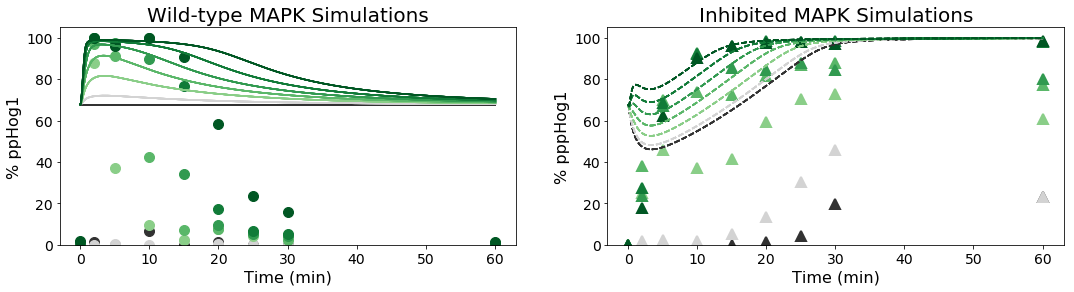

In [256]:
plt_param_behaviors(pPTP, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

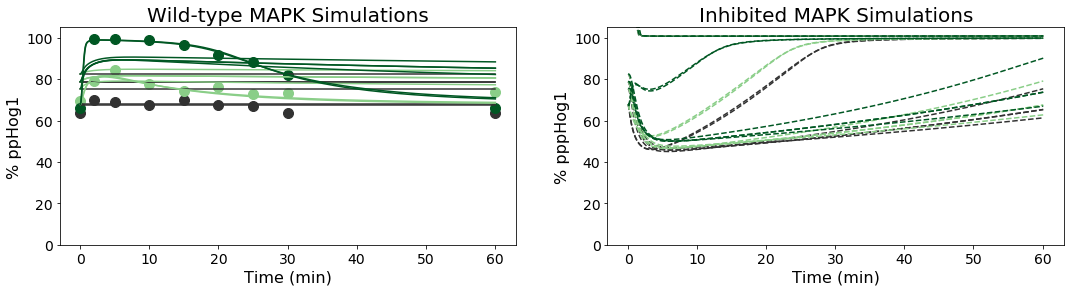

In [257]:
plt_param_behaviors_consts_diff(pPTP, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

## Calculate Ttest

In [ ]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_ptp23, df_top_params_M4, axis=0)
print(ttest)

# lowest and only significant p value: kM5 - 0.04342801 (with top 20, threshold = 15)

In [285]:
df_top_params_ptp23D.head()

0            1             2            3         4           5   \
0   0.010712  1692.942079  4.228689e-04  7205.043965  0.001003  144.914300   
1  41.713439    32.664873  4.492760e-02   420.471761  0.000100    1.807369   
2   0.225876     0.000136  1.013018e+05   557.218048  0.000100    0.020627   
3   5.597930  1574.457652  9.801579e+07  2974.704329  0.000886    4.334163   
4   0.040350   172.772615  6.012122e+00  9999.979295  0.003803    2.369919   

            6            7            8            9      ...             12  \
0  2859.636207     0.000856     0.011004  3710.119446     ...       0.011099   
1    23.942093    19.182888     0.000882    87.656554     ...       0.015050   
2  7059.476445     0.105184  7850.092417    65.615658     ...       0.007773   
3  9999.883296  5990.823419   156.134936   796.682021     ...       0.014031   
4  5479.968412     0.417353     0.000100     0.009122     ...       0.019346   

            13          14        15        16        17        18  \
0     0.000519    0.000188  0.411894  6.714878  0.057765  0.000391   
1     0.003157    0.000150  0.006850  0.001594  0.477221  0.000388   
2     0.002768    0.000100  0.000244  0.000508  0.000895  0.000137   
3  8050.395981    0.107414  0.000100  0.000100  0.013144  0.371169   
4    20.506867  364.728802  0.000883  0.000156  0.946803  0.000604   

            19           20           21  
0     0.000391     0.605209     0.003179  
1     0.174175  1955.861510  3775.835545  
2  9768.343302  2851.737031     0.000134  
3    42.903399     0.054070    12.643423  
4    77.013994     6.875810   117.348369  

[5 rows x 22 columns]

In [286]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_ptp23D, df_top_params_M4, axis=0)
print(ttest)
np.argwhere(ttest[1]<0.05)

Ttest_indResult(statistic=array([-1.02085167, -3.5734863 , -0.87598478,  0.44899065, -1.29098353,
        0.36156145,  2.98272483, -0.26027296,  0.58371054, -0.354354  ,
       -0.31826768,  0.89131759,  4.70668037,  1.80631899, -1.54782571,
        0.9168005 ,  1.03834938, -0.18340783, -0.23651286, -0.71724111,
       -0.63101826,  2.13448366]), pvalue=array([3.13780223e-01, 9.77982414e-04, 3.86542241e-01, 6.55988642e-01,
       2.04508350e-01, 7.19682490e-01, 4.96801810e-03, 7.96058405e-01,
       5.62864044e-01, 7.25032513e-01, 7.52024525e-01, 3.78367974e-01,
       3.30444559e-05, 7.87933657e-02, 1.29953190e-01, 3.65029318e-01,
       3.05669680e-01, 8.55453172e-01, 8.14305029e-01, 4.77611290e-01,
       5.31805939e-01, 3.93143968e-02]))


array([[ 1],
       [ 6],
       [12],
       [21]], dtype=int64)

In [ ]:
df_top_params_M4

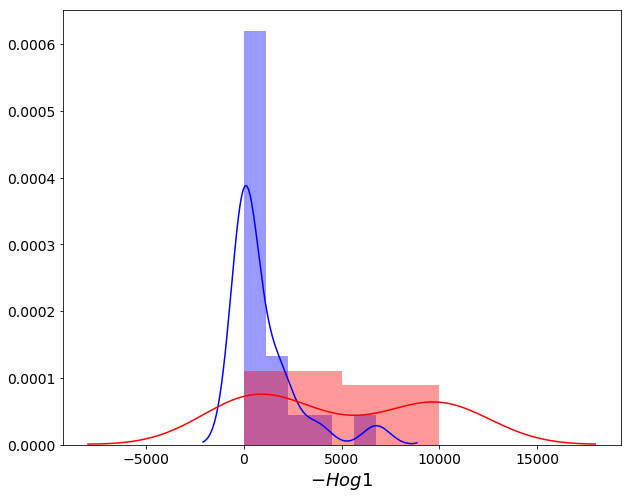

In [296]:
sns.distplot(df_top_params_ptp23D.iloc[:,1],color='blue')
sns.distplot(df_top_params_M4.iloc[:,1], color='red')

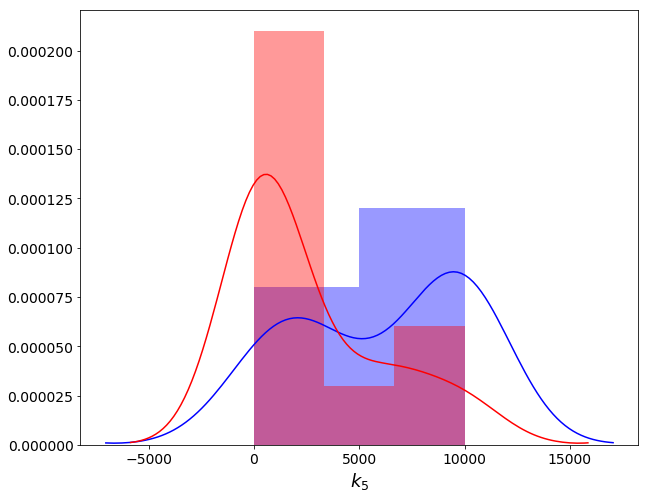

In [297]:
sns.distplot(df_top_params_ptp23D.iloc[:,6],color='blue')
sns.distplot(df_top_params_M4.iloc[:,6], color='red')

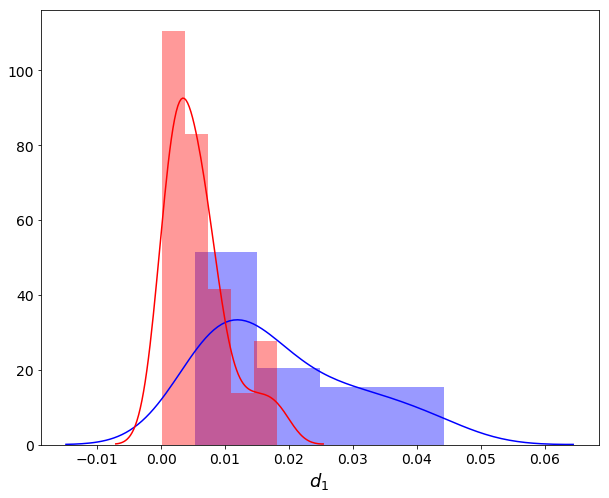

In [298]:
sns.distplot(df_top_params_ptp23D.iloc[:,12],color='blue')
sns.distplot(df_top_params_M4.iloc[:,12], color='red')

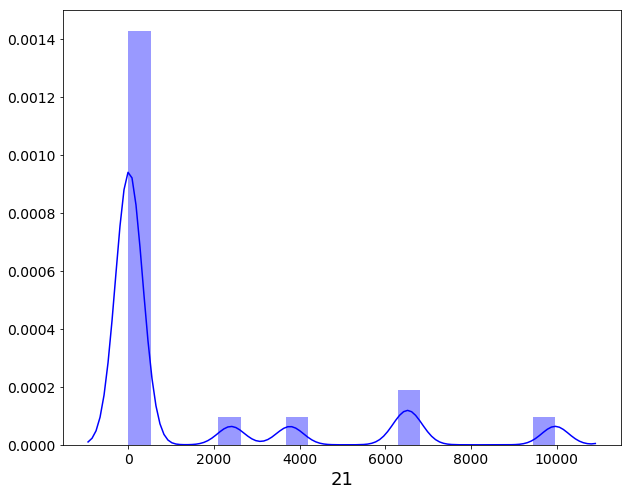

In [301]:
sns.distplot(df_top_params_ptp23D.iloc[:,21],color='blue')
# sns.distplot(df_top_params_M4.iloc[:,21], color='red')

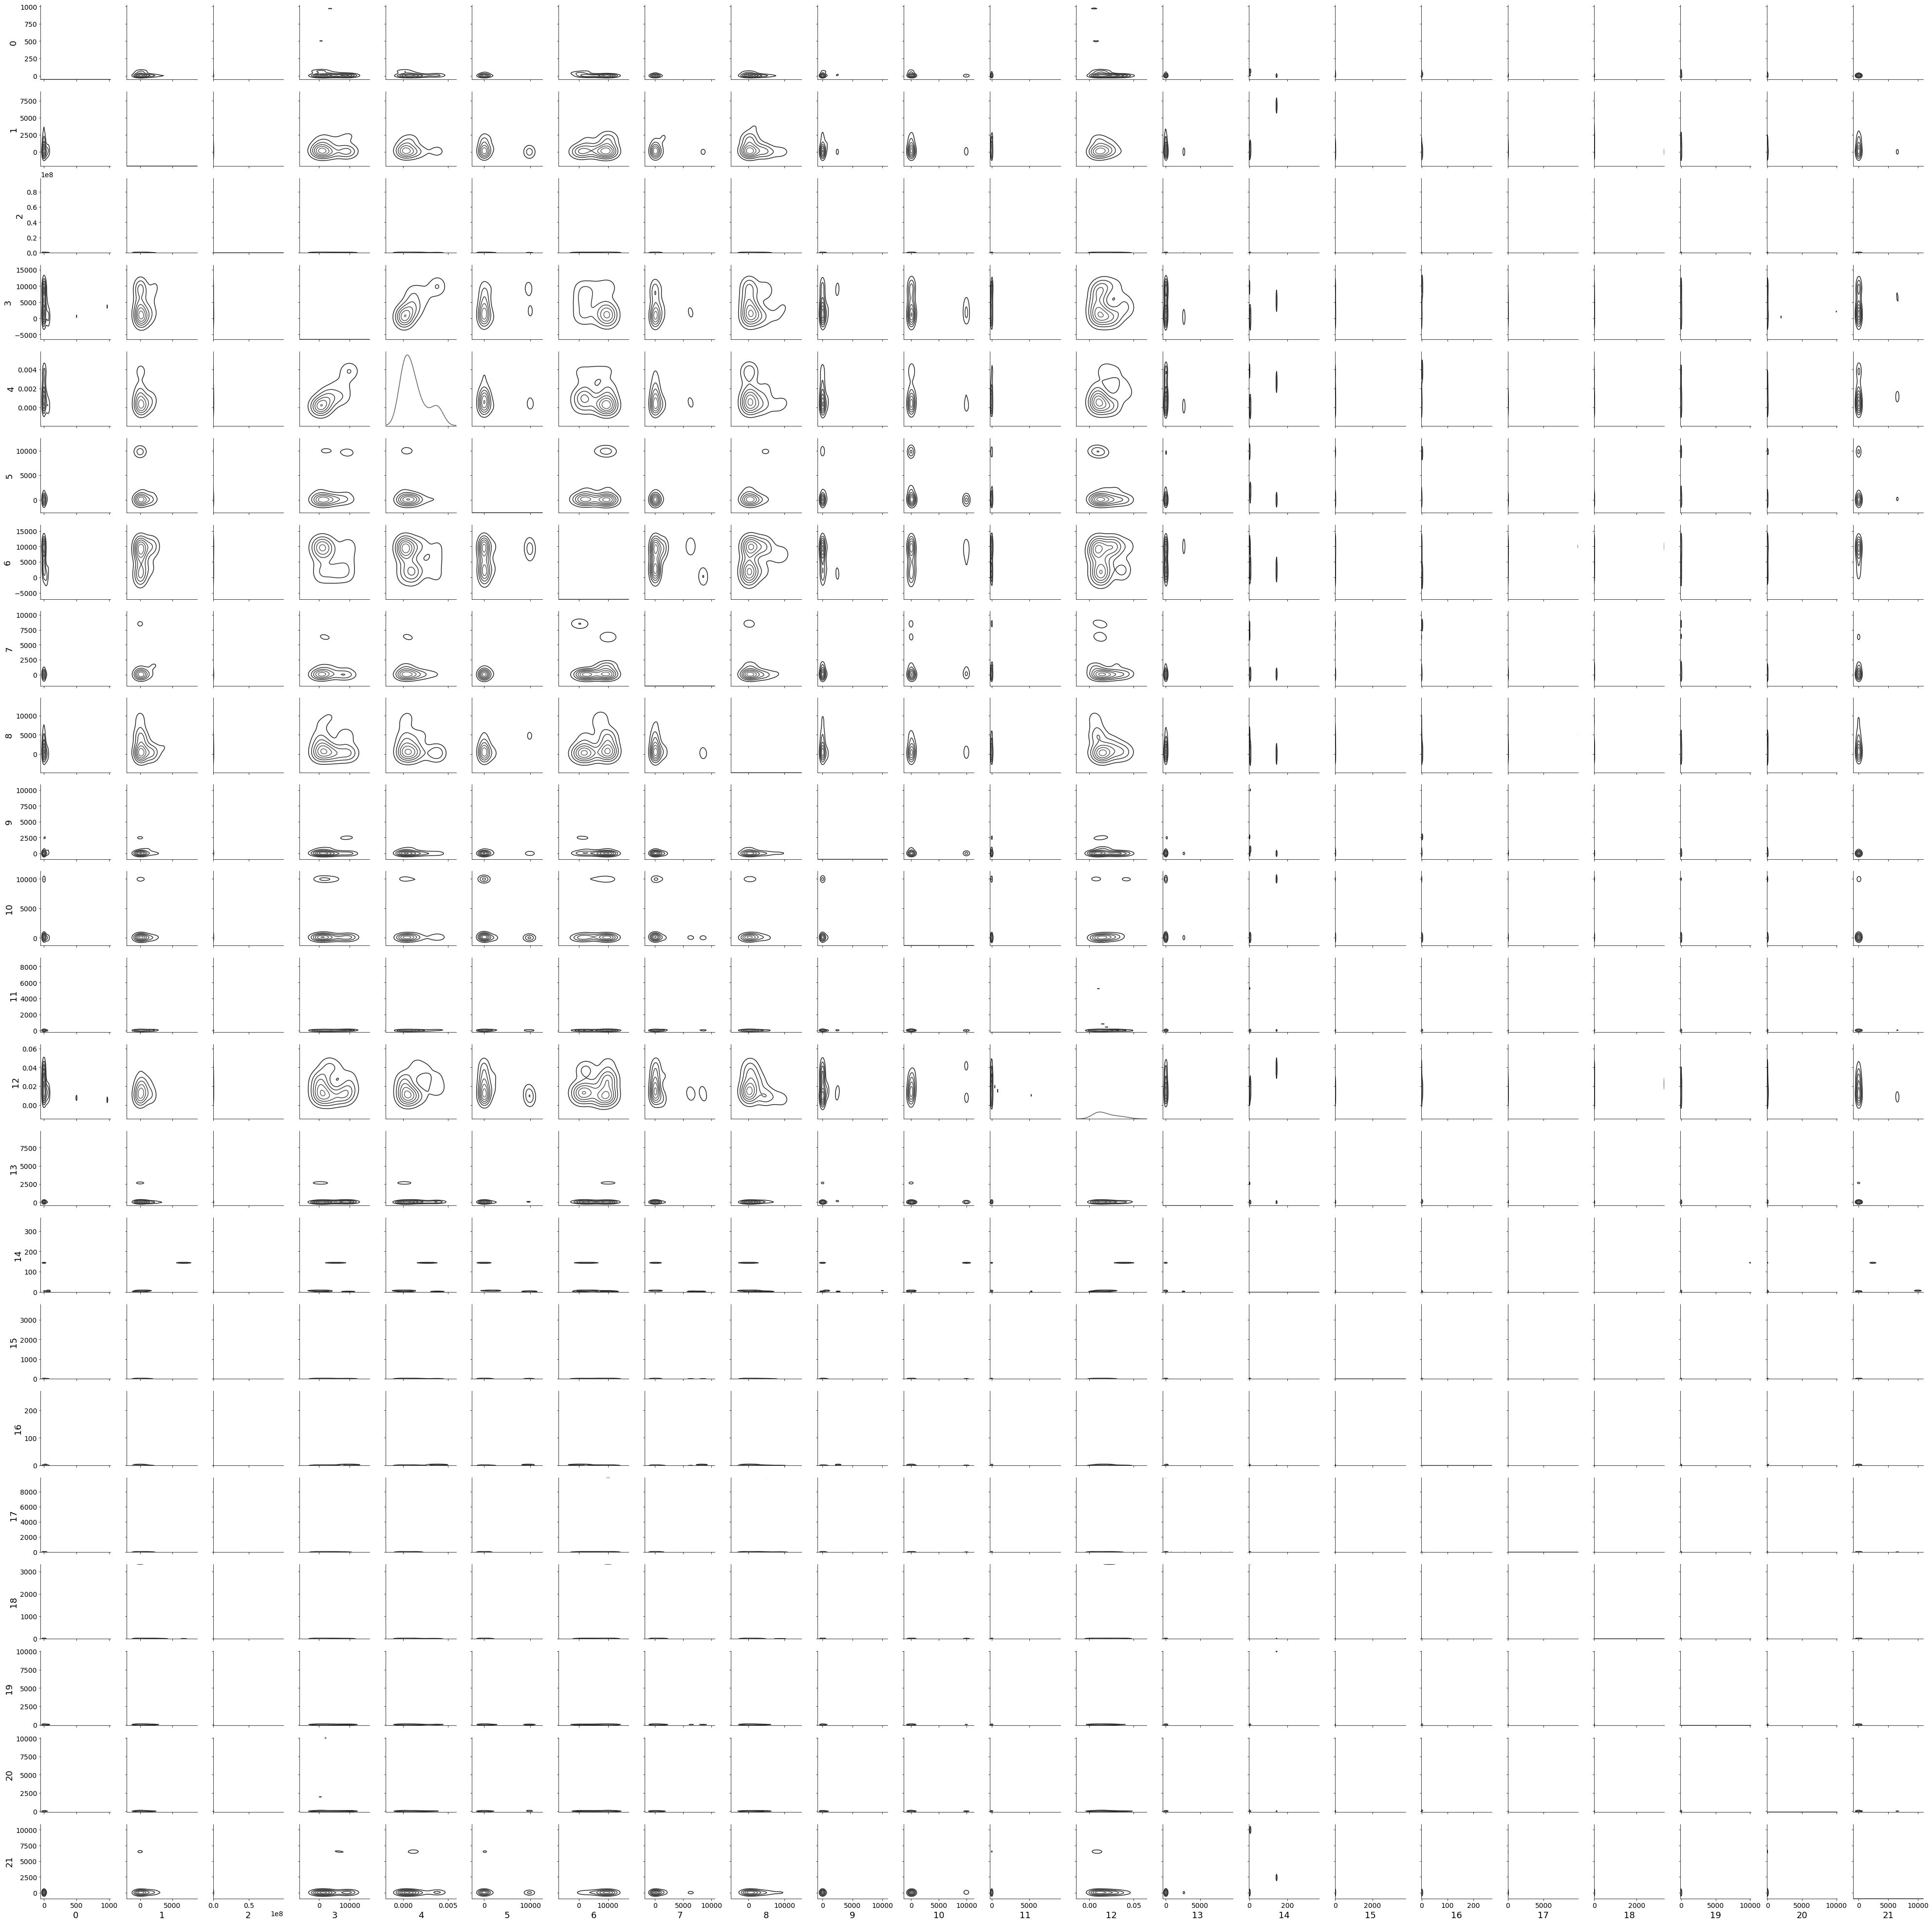

In [288]:
g = sns.PairGrid(df_top_params_ptp23D)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

Tukey's test (honing in on two comparisons of the group) for ANOVA (summary statistic comparing all of the groups) correcting for multiple testing https://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/

## Calculate score

In [290]:
hog1_doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
pbs2_doses = [150000, 550000]
ptp_doses = [0, 150000, 550000]

for params in top_params_a1_1D[:10]:
    print(scorefxn(initials, params_constants, params))

[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.361472, 4.18506, 19.49207995, 23.08120093, 23.78618578, 22.3375094, 31.67199502, 36.30961501, 33.02963546, 34.87627365]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: operands could not be broadcast together with shapes (9,) (15,) 